In [1]:
import datetime
import os
import pprint

import numpy as np
from copy import deepcopy
from tianshou.data.buffer.vecbuf import VectorReplayBuffer, ReplayBuffer
from tianshou.env.venvs import SubprocVectorEnv
import torch
from torch.utils.tensorboard import SummaryWriter
from env.risky_pointmass import PointMass
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go

from tianshou.data import Collector, Batch, to_torch
from tianshou.data.types import RolloutBatchProtocol
from tianshou.policy import DSACPolicy, BasePolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import ActorProb, QuantileMlp

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shim

In [2]:
task = "PointMass"
seed = 0
risk_type = "wang"
buffer_size = 1000000
hidden_sizes = [256, 256, 256]
actor_lr = 3e-4
critic_lr = 3e-4
gamma = 0.99
tau = 0.005
alpha = 0.02
auto_alpha = True
exploration = True
alpha_lr = 3e-4
start_timesteps = 10000
epoch = 200
step_per_epoch = 500
step_per_collect = 1
update_per_step = 1
n_step = 1
batch_size = 256
training_num = 1
test_num = 10
logdir = "log"
device = "cuda:2"

In [3]:
distortion_param = -0.75
risk_penalty = 20
risk_prob = 0.95
high_state = 1.5
env = PointMass(risk_penalty=risk_penalty, risk_prob=risk_prob, high_state=high_state)

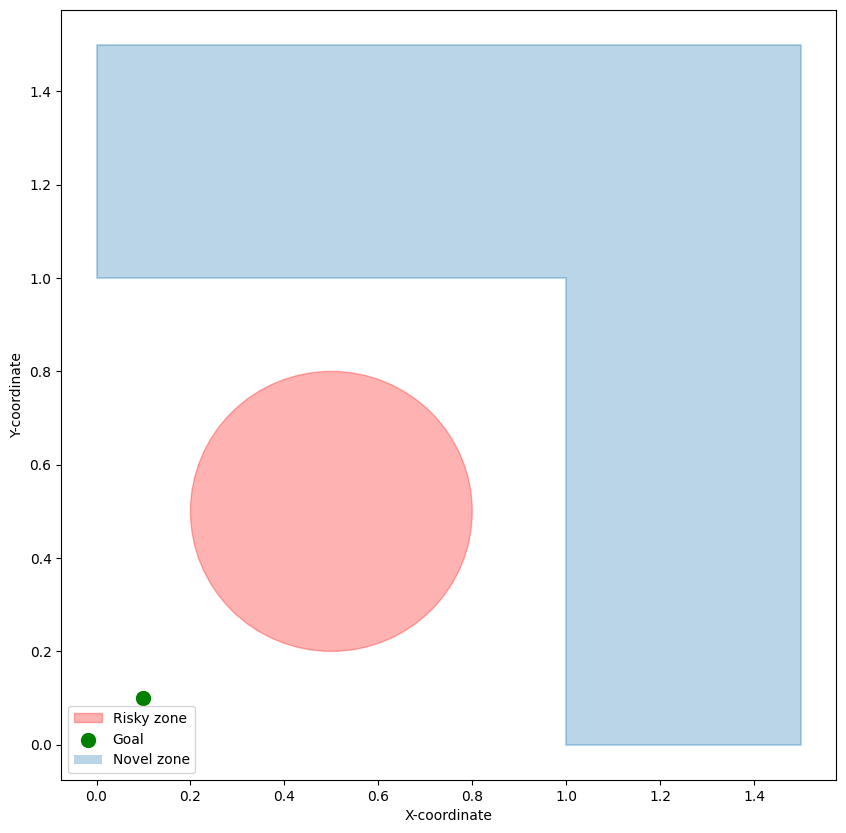

In [4]:
# Create a figure for plotting
plt.figure(figsize=(10, 10))

x = [1, 1, 0, 0, 1.5, 1.5, 1]  
y = [0, 1, 1, 1.5, 1.5, 0, 0]

# Plot the risk area
circle = plt.Circle(env.center, 0.3, color='red', alpha=0.3, label='Risky zone')
plt.gca().add_patch(circle)

# Plot the goal
plt.scatter(*env.goal, color='green', marker='o', s=100, label='Goal')
plt.plot(x, y, alpha=0.3)
plt.fill(x, y, alpha=0.3, label='Novel zone')  

plt.legend()
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.show()  

In [5]:
train_envs = SubprocVectorEnv([lambda: PointMass(risk_penalty=risk_penalty, risk_prob=risk_prob, high_state=high_state) for _ in range(training_num)])
test_envs = SubprocVectorEnv([lambda: PointMass(risk_penalty=risk_penalty, risk_prob=risk_prob, high_state=high_state) for _ in range(test_num)])
state_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n
max_action = env.action_space.high[0]
print("Observations shape:", state_shape)
print("Actions shape:", action_shape)
print("Action range:", np.min(env.action_space.low), np.max(env.action_space.high))
# seed
np.random.seed(seed)
torch.manual_seed(seed)
# model
net_a = Net(state_shape, hidden_sizes=hidden_sizes, device=device)
actor = ActorProb(
    net_a,
    action_shape,
    device=device,
    unbounded=True,
    conditioned_sigma=True,
).to(device)
actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)

critic1 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=critic_lr)
critic2 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=critic_lr)

if auto_alpha:
    target_entropy = -np.prod(env.action_space.shape)
    log_alpha = torch.zeros(1, requires_grad=True, device=device)
    alpha_optim = torch.optim.Adam([log_alpha], lr=alpha_lr)
    alpha = (target_entropy, log_alpha, alpha_optim)

policy = DSACPolicy(
    actor,
    actor_optim,
    critic1,
    critic1_optim,
    critic2,
    critic2_optim,
    risk_type=risk_type,
    tau=tau,
    gamma=gamma,
    alpha=alpha,
    estimation_step=n_step,
    action_space=env.action_space,
    distortion_param=distortion_param,
    device=device,
)

# collector
buffer = VectorReplayBuffer(buffer_size, training_num)
train_collector = Collector(policy, train_envs, buffer, exploration_noise=exploration)
test_buffer = VectorReplayBuffer(1000*test_num, test_num)
test_collector = Collector(policy, test_envs, test_buffer)

Observations shape: (2,)
Actions shape: (2,)
Action range: -0.05 0.05


In [6]:
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
algo_name = "dsac"
risk_ = ""
if risk_type in ["wang", "cvar"]:
    risk_ = risk_type + str(distortion_param)
log_name = os.path.join(task+f"_prob{risk_prob}"+f"_pen{risk_penalty}"+f"_hs{high_state}", algo_name, risk_, str(seed), now)
log_path = os.path.join(logdir, log_name)
print(f"log path: {log_path}")

# logger
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

log path: log/PointMass_prob0.95_pen20_hs1.5/dsac/wang-0.75/0/240119-121926


In [6]:
def save_best_fn(policy):
    torch.save(policy.state_dict(), os.path.join(log_path, "best.pth"))

def test_fn(num_epoch: int, step_idx: int):
    torch.save(policy.state_dict(), os.path.join(log_path, "policy.pth"))

In [ ]:
result = OffpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=epoch,
    step_per_epoch=step_per_epoch,
    step_per_collect=step_per_collect,
    episode_per_test=test_num,
    batch_size=batch_size,
    save_best_fn=save_best_fn,
    test_fn=test_fn,
    logger=logger,
    update_per_step=update_per_step,
    test_in_train=False,
).run()
pprint.pprint(result)

In [6]:
def get_init_states(n=50, seed=None):
    if seed is not None:
        np.random.seed(seed)
    x_grid = np.linspace(0.4, 1.5, 101)
    y_grid = np.linspace(0.4, 1.5, 101)
    init_states = np.stack([(x, y) for x in x_grid for y in y_grid])
    init_states = np.array([(x, y) for x, y in init_states if np.linalg.norm(np.array((x,y))-env.center) > env.r])
    init_states = init_states[np.random.choice(len(init_states), n)]
    return init_states   

def plot_trajectories(policy, X=None, Y=None, Z=None):
    policy.eval()
    init_states = get_init_states()
    trajectories = []
    for state in init_states:
        obs, info = env.reset(init_state=state)
        done = False
        cum_reward = 0
        actions = []
        while not done:
            batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(device), info=info)
            with torch.no_grad():
                result = policy(batch)
            act = result.act.cpu().squeeze().numpy()
            act = policy.map_action(act)
            obs, reward, terminated, truncated, info = env.step(act)
            actions.append(act)
            cum_reward += reward
            done = terminated or truncated 
        trajectories.append(env.trajectory)

    # Create a figure for plotting
    plt.figure(figsize=(10, 10))

    # Novel zone coordinates
    x = [1, 1, 0, 0, 1.5, 1.5, 1]  
    y = [0, 1, 1, 1.5, 1.5, 0, 0]

    # Plot the risk area
    circle = plt.Circle((0.5, 0.5), 0.3, color='red', alpha=0.3, label="Risk zone")
    plt.gca().add_patch(circle)

    # Plot the novel area
    plt.plot(x, y, alpha=0.3)
    plt.fill(x, y, alpha=0.3, label='Novel zone')  

    # Plot the goal
    circle = plt.Circle(env.goal, 0.01, color='green', label="Goal")
    plt.gca().add_patch(circle)

    # Plot the start states
    plt.scatter(*zip(*init_states), color='blue', marker='o', s=10, label='Start States')

    # Plot the trajectories
    for traj in trajectories:
        plt.plot(*zip(*traj), color='gray', linewidth=1, alpha=0.3)

    if X is not None:
        contour = plt.contourf(X, Y, Z>=0, cmap='viridis', alpha=0.3)
        # Create custom legend labels
        legend_labels = {1: "Safe policy takes over", 0: "Suboptimal policy takes over"}
        # Create custom legend patches
        labels = ["Safe policy takes over", "Suboptimal policy takes over"]
        colors = [contour.cmap(contour.norm(value)) for value in (1, 0)]
        patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

        # Add legend with custom patches
        plt.legend(handles=patches)

    plt.legend()
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Trajectories from Start States to Goal')
    plt.show()      

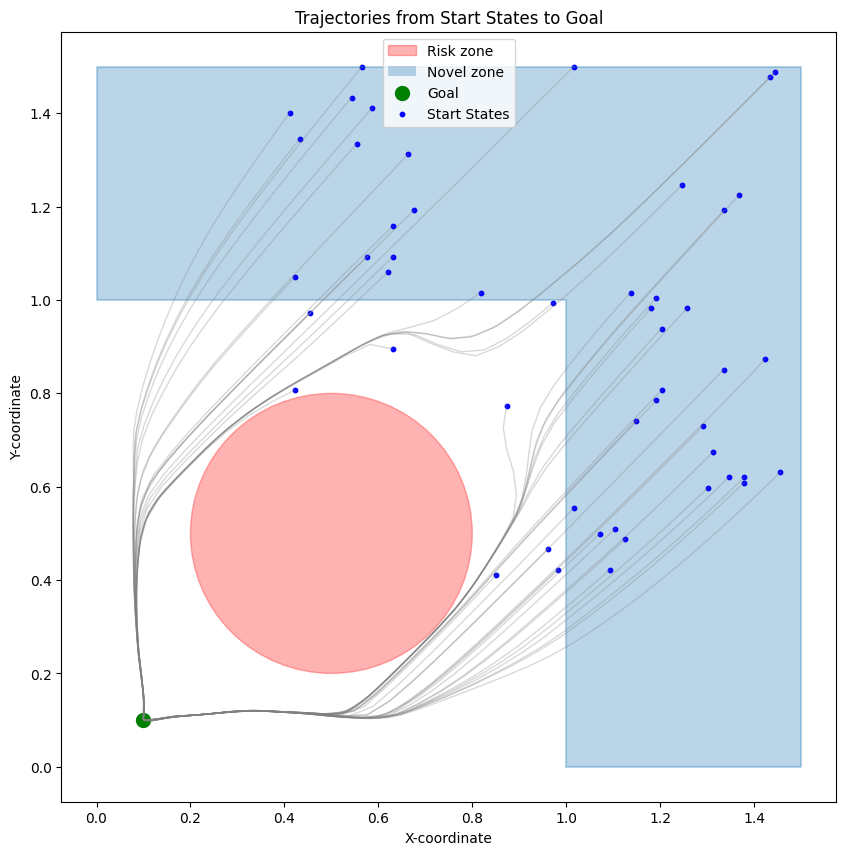

In [ ]:
plot_trajectories(policy)

In [8]:
n_samples = 100
x_grid = np.linspace(0, 1, 101)
y_grid = np.linspace(0, 1, 101)
z_values = np.zeros((101, 101))
for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        env.state = np.array((x,y))
        if not env.is_safe():
            z = 0
            for _ in range(n_samples):
                reward, _ = env.get_reward()
                z += reward
            z_values[i, j] = z/n_samples
        else:
            reward, _ = env.get_reward()
            z_values[i, j] = reward

In [58]:
# Create a 2D contour plot
fig = go.Figure(data=[go.Contour(z=z_values, x=x_grid, y=y_grid)])

# Customize the layout
fig.update_layout(title='Rewards', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

# Show the plot
fig.show()

In [8]:
def load_policy(path, distortion_param=distortion_param, alpha=alpha):
    net_a = Net(state_shape, hidden_sizes=hidden_sizes, device=device)
    actor = ActorProb(
        net_a,
        action_shape,
        device=device,
        unbounded=True,
        conditioned_sigma=True,
    ).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)

    critic1 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=critic_lr)
    critic2 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=critic_lr)

    if auto_alpha:
        target_entropy = -np.prod(env.action_space.shape)
        log_alpha = torch.tensor([np.log(0.02)], requires_grad=True, device=device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=alpha_lr)
        alpha = (target_entropy, log_alpha, alpha_optim)

    policy = DSACPolicy(
        actor,
        actor_optim,
        critic1,
        critic1_optim,
        critic2,
        critic2_optim,
        risk_type=risk_type,
        tau=tau,
        gamma=gamma,
        alpha=alpha,
        estimation_step=n_step,
        action_space=env.action_space,
        distortion_param=distortion_param,
        device=device,
    )
    policy.load_state_dict(torch.load(path, map_location=device))
    print("Loaded agent from: ", path)
    return policy

# Epistemic Uncertainty

In [92]:
def epistemic_uncertainty(paths, states):
    states = Batch(obs=states, info={})
    policies = [load_policy(p) for p in paths]
    policies = [p.eval() for p in policies]
    results = np.stack([p(states).act.cpu().detach().numpy() for p in policies])
    return np.mean(np.std(results, 0), -1)

In [61]:
path1 = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/0/240110-092605/policy.pth"
path2 = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/123/240110-094642/policy.pth"
path3 = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/159/240110-145011/policy.pth"
path4 = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/456/240110-101135/policy.pth"
path5 = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/789/240110-104245/policy.pth"

paths = [path1, path2, path3, path4, path5]

In [88]:
states = (torch.rand(1000, 2) * 1.5).to(device)

In [93]:
uncertainties = epistemic_uncertainty(paths, states)

Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/0/240110-092605/policy.pth
Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/123/240110-094642/policy.pth
Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/159/240110-145011/policy.pth
Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/456/240110-101135/policy.pth
Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen10_hs1/dsac/wang-0.75/789/240110-104245/policy.pth


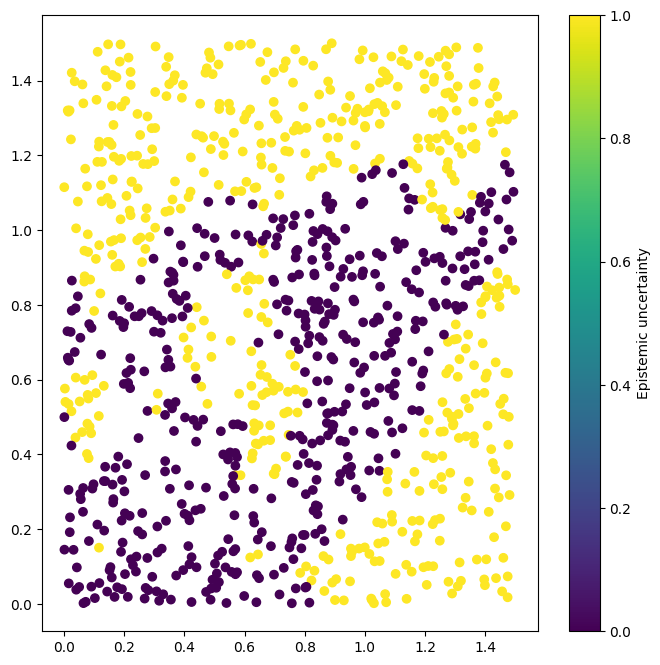

In [94]:
plt.figure(figsize=(8, 8))
sc = plt.scatter(states.cpu()[:, 0], states.cpu()[:, 1], c=uncertainties>0.05, cmap='viridis')
plt.colorbar(sc, label='Epistemic uncertainty')
plt.show()

# Novelty using KDE

In [ ]:
# Generate ID data points within the unit square
n_id_points = 1000
n_new_points = 5
id_data = np.random.uniform(0, 1, (n_id_points, 2))

for _ in range(20):
    new_id_data_x = np.random.uniform(0, 1, n_new_points)
    new_id_data_y = np.random.uniform(1, 1.5, n_new_points)
    id_data = np.concatenate([id_data, list(zip(new_id_data_x, new_id_data_y))])
    new_id_data_y = np.random.uniform(0, 1, n_new_points)
    new_id_data_x = np.random.uniform(1, 1.5, n_new_points)
    id_data = np.concatenate([id_data, list(zip(new_id_data_x, new_id_data_y))])
    new_id_data = np.random.uniform(1, 1.5, (n_new_points, 2))
    id_data = np.concatenate([id_data, new_id_data])

    # Fit KDE to ID data
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(id_data)

    # Generate test points
    n_test_points = 1000
    test_data = np.random.uniform(0, 1.5, (n_test_points, 2))

    # Compute log density scores
    log_dens = kde.score_samples(test_data)
    density_threshold = np.percentile(kde.score_samples(id_data), 5)  # Threshold at the 10th percentile

    # Classify as ID or OOD
    is_id = log_dens > density_threshold

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.scatter(id_data[:, 0], id_data[:, 1], c='blue', label='ID Data')
    plt.scatter(test_data[is_id, 0], test_data[is_id, 1], c='green', label='Classified as ID')
    plt.scatter(test_data[~is_id, 0], test_data[~is_id, 1], c='red', label='Classified as OOD')
    plt.title('OOD Classification using KDE')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.show()

Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20_hs1.5/dsac/wang0.75/0/240111-114541/policy.pth


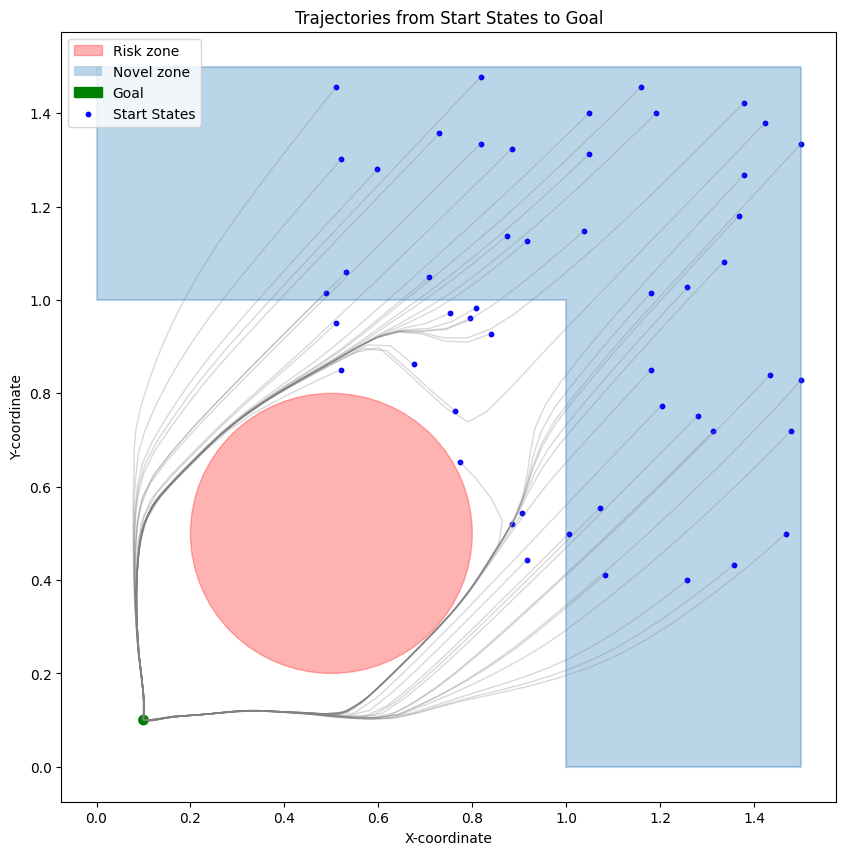

In [9]:
safe_policy_path = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20_hs1.5/dsac/wang0.75/0/240111-114541/policy.pth"
safe_policy = load_policy(safe_policy_path)
plot_trajectories(safe_policy)

Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20/dsac/wang-0.75/0/240116-111416/policy.pth


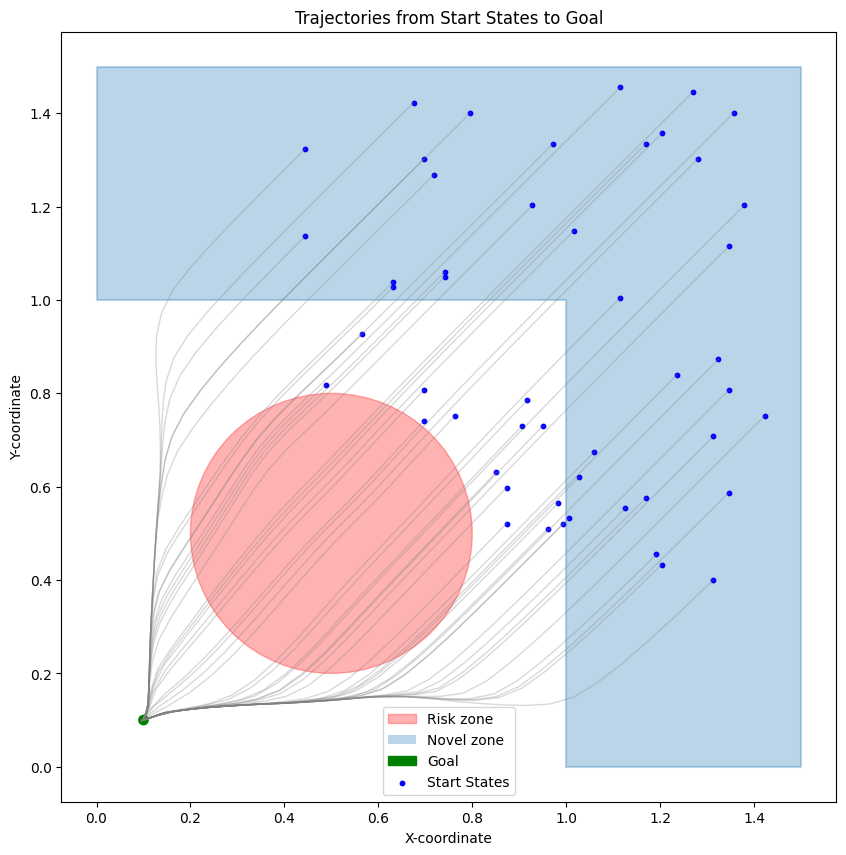

In [56]:
risky_policy_path = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20/dsac/wang-0.75/0/240116-111416/policy.pth"
risky_policy =  load_policy(risky_policy_path, distortion_param=0.75)
plot_trajectories(risky_policy)

In [13]:
def get_qvalues(policy):
    policy.eval()
    x_grid = np.linspace(0, 1, 21)
    y_grid = np.linspace(0, 1, 21)
    init_states = np.array([(i, j) for i in x_grid for j in y_grid])
    qs = []
    for state in init_states:
        batch = Batch(obs=torch.from_numpy(np.expand_dims(state, 0)).to(dtype=torch.float32, device=device), info={})
        with torch.no_grad():
            result = policy(batch)
            q_values1 = policy.critic1(batch.obs, result.act)
            q_values2 = policy.critic2(batch.obs, result.act)
            q_values = torch.minimum(q_values1, q_values2).cpu().numpy()
        qs.append(q_values)
    return np.array(qs).squeeze()

In [14]:
rvs = []
for _ in range(10):
    risky_qvalues = get_qvalues(risky_policy)
    rvs.append(risky_qvalues)

In [15]:
svs = []
for _ in range(10) :
    safe_qvalues = get_qvalues(safe_policy)
    svs.append(safe_qvalues)

In [16]:
rvs = np.stack(rvs)
svs = np.stack(svs)

In [73]:
rvs.std(0)

array([[0.03707572, 0.04501012, 0.03513948, ..., 0.01435305, 0.01129485,
        0.0092881 ],
       [0.01781376, 0.02595732, 0.02466226, ..., 0.01660345, 0.01175874,
        0.01153434],
       [0.03243154, 0.01203604, 0.0194042 , ..., 0.02206246, 0.01738688,
        0.00587759],
       ...,
       [0.05784888, 0.23133643, 0.42780417, ..., 0.13083875, 0.16713889,
        0.12402661],
       [0.07696366, 0.23864172, 0.451774  , ..., 0.20406523, 0.15232301,
        0.09120448],
       [0.07988867, 0.20172186, 0.38525727, ..., 0.09691892, 0.16852897,
        0.04551736]], dtype=float32)

In [66]:
list(zip(risky_qvalues[:, 0], safe_qvalues[:, 0]))

[(0.0041394066, 0.2262283),
 (0.20574783, 0.3260094),
 (0.35089895, 0.30505076),
 (0.2673406, 0.3000074),
 (0.23451476, 0.21833248),
 (0.0057549197, -0.056320127),
 (-0.29120836, -0.33221218),
 (-0.7778208, -0.66906947),
 (-1.1347938, -1.0747694),
 (-1.7814921, -1.5482961),
 (-2.1846228, -2.0496757),
 (-2.7927136, -2.5960143),
 (-3.5342891, -3.4051142),
 (-4.1639633, -3.8673766),
 (-4.9858527, -4.5588975),
 (-5.5522213, -5.332461),
 (-6.4454417, -6.2593336),
 (-7.4128833, -7.0017347),
 (-8.649091, -8.034294),
 (-9.196196, -8.942784),
 (-9.829485, -10.291324),
 (0.14405486, 0.28897032),
 (0.41668606, 0.50088227),
 (0.44272357, 0.5120711),
 (0.44911706, 0.41434306),
 (0.30377784, 0.29834777),
 (-0.09774711, 0.012985308),
 (-0.2287165, -0.24507862),
 (-0.5709644, -0.6131703),
 (-0.968763, -0.9944559),
 (-1.5963882, -1.4658467),
 (-2.1688426, -1.9581516),
 (-2.7215471, -2.5938497),
 (-3.4431646, -3.2812703),
 (-3.971015, -3.8771133),
 (-4.8736362, -4.5560217),
 (-5.6334567, -5.332183),
 (-

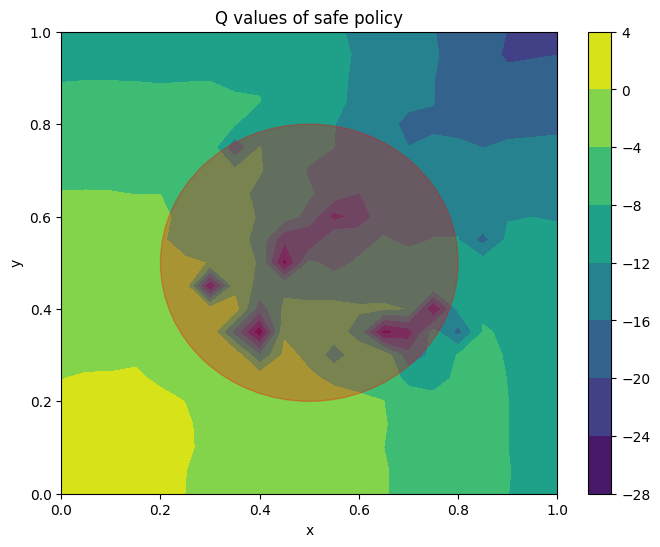

In [17]:
X = np.linspace(0, 1, 21)
Y = np.linspace(0, 1, 21)
Z = safe_qvalues[:, 0]
# Reshape Z to a 21x21 grid
Z_reshaped = Z.reshape(21, 21)

# Create a meshgrid for X and Y
X, Y = np.meshgrid(X, Y)

# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z_reshaped, cmap='viridis')
# Plot the risk area
circle = plt.Circle((0.5, 0.5), 0.3, color='red', alpha=0.3, label="Risk zone")

plt.colorbar(contour)
plt.gca().add_patch(circle)
plt.title('Q values of safe policy')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

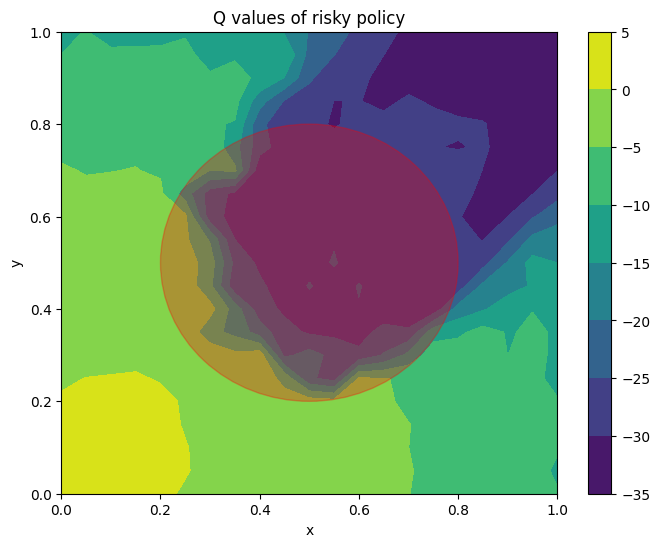

In [18]:
Z = risky_qvalues[:, 0]
# Reshape Z to a 21x21 grid
Z_reshaped = Z.reshape(21, 21)

# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z_reshaped, cmap='viridis')
# Plot the risk area
circle = plt.Circle((0.5, 0.5), 0.3, color='red', alpha=0.3, label="Risk zone")

plt.colorbar(contour)
plt.gca().add_patch(circle)
plt.title('Q values of risky policy')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

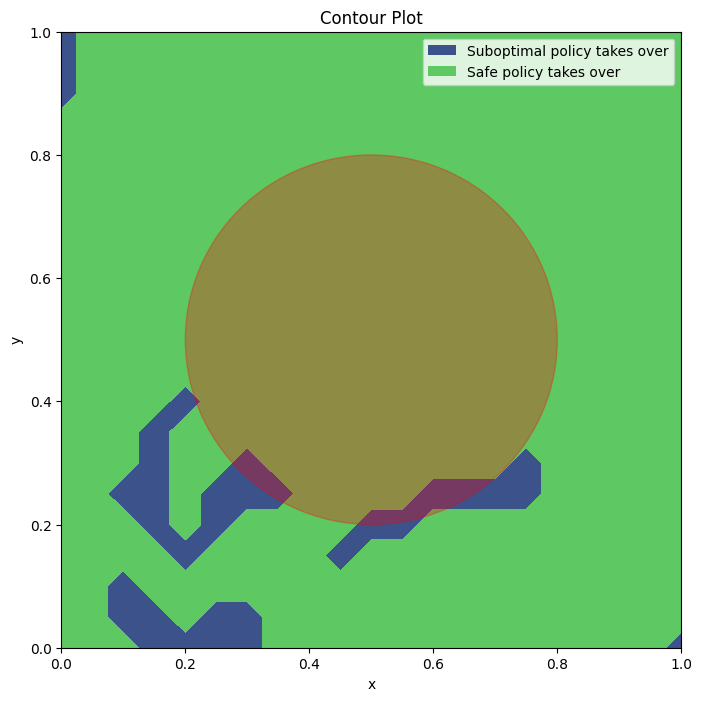

In [19]:
Z = -rvs.mean(0)[:, 0] + svs.mean(0)[:, 0]

# Reshape Z to a 21x21 grid
Z_reshaped = Z.reshape(21, 21)

# Create contour plot
plt.figure(figsize=(8, 8))
contour = plt.contourf(X, Y, Z_reshaped>0, cmap='viridis')
# Plot the risk area
circle = plt.Circle((0.5, 0.5), 0.3, color='red', alpha=0.3, label="Risk zone")
# Create custom legend labels
legend_labels = {1: "Safe policy takes over", 0: "Suboptimal policy takes over"}
# Add legend with custom labels
handles, _ = contour.legend_elements()
plt.legend(handles, [legend_labels[i] for i in range(2)])
plt.gca().add_patch(circle)
plt.title('Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [57]:
class MixedPolicy(BasePolicy):
    def __init__(self, base_policy: BasePolicy, expert_policy: BasePolicy, action_space, id_data):
        super().__init__(action_space=action_space, action_scaling=True)
        self.base_policy = base_policy
        self.expert_policy = expert_policy
        self.update_kde(id_data)
        self.cede_ctrl_prob = 1

    def update_kde(self, id_data):
        self.kde = KernelDensity(kernel='epanechnikov', bandwidth=0.1).fit(id_data)
        self.density_threshold = np.percentile(self.kde.score_samples(id_data), 1)  

    def forward(self, batch: RolloutBatchProtocol, state=None, n_repeat=100, **kwargs):
        bsz = len(batch.obs)
        batch = to_torch(batch, dtype=torch.float32, device=device)
        _batch = Batch(**{'obs': deepcopy(batch.obs.repeat(n_repeat, 1)), 'info': None})
        self.base_policy.eval()
        self.expert_policy.eval()
        with torch.no_grad():
            expert_result = self.expert_policy(_batch)
            base_result = self.base_policy(_batch)
            repeated_expert_qvalues1 = self.expert_policy.critic1(_batch.obs, expert_result.act).reshape(n_repeat, bsz, -1)
            repeated_expert_qvalues2 = self.expert_policy.critic2(_batch.obs, expert_result.act).reshape(n_repeat, bsz, -1)
            expert_qvalues1 = repeated_expert_qvalues1.mean(0)
            expert_qvalues2 = repeated_expert_qvalues2.mean(0)
            expert_qvalues1_std = repeated_expert_qvalues1.std(0)
            expert_qvalues2_std = repeated_expert_qvalues2.std(0)
            expert_qvalues_std = (expert_qvalues1_std + expert_qvalues2_std) * .5
            expert_qvalues = torch.minimum(expert_qvalues1, expert_qvalues2)
            repeated_base_qvalues1 = self.base_policy.critic1(_batch.obs, base_result.act).reshape(n_repeat, bsz, -1)
            repeated_base_qvalues2 = self.base_policy.critic2(_batch.obs, base_result.act).reshape(n_repeat, bsz, -1)
            base_qvalues1 = repeated_base_qvalues1.mean(0)
            base_qvalues2 = repeated_base_qvalues2.mean(0)
            base_qvalues1_std = repeated_base_qvalues1.std(0)
            base_qvalues2_std = repeated_base_qvalues2.std(0)
            base_qvalues = torch.minimum(base_qvalues1, base_qvalues2)
            base_qvalues_std = (base_qvalues1_std + base_qvalues2_std) * .5
        risky = base_qvalues[:, 0] - base_qvalues_std[:, 0] < expert_qvalues[:, 0] - expert_qvalues_std[:, 0]
        log_dens = self.kde.score_samples(batch.obs.cpu().numpy())
        novel = log_dens < self.density_threshold
        novel = to_torch(novel, dtype=torch.float32, device=device)
        cede_ctrl = torch.logical_or(risky, novel)
        # if bsz == 1:
        #     not_cede_ctrl = ~cede_ctrl * (torch.rand(1, device=device) >= self.cede_ctrl_prob)
        #     cede_ctrl = ~not_cede_ctrl
        cede_ctrl = cede_ctrl.unsqueeze(-1)
        actions = torch.where(cede_ctrl, expert_result.act[0], base_result.act[0])
        self.cede_ctrl_prob *= 0.99999
        return Batch(**{'act': actions, 'policy': Batch({'cede_ctrl': cede_ctrl, 'novel': novel, 'risky': risky})})

    def train(self, mode: bool = True) -> "MixedPolicy":
        self.base_policy.train(mode)
        return self
    
    def process_fn(self, batch: RolloutBatchProtocol, buffer: ReplayBuffer, indices: np.ndarray) -> RolloutBatchProtocol:
        return self.base_policy.process_fn(batch, buffer, indices)

    def learn(self, batch, **kwargs):
        # cede_ctrl = batch.policy.cede_ctrl.cpu().squeeze()
        # batch = batch[~cede_ctrl]
        info = self.base_policy.learn(batch)
        return info

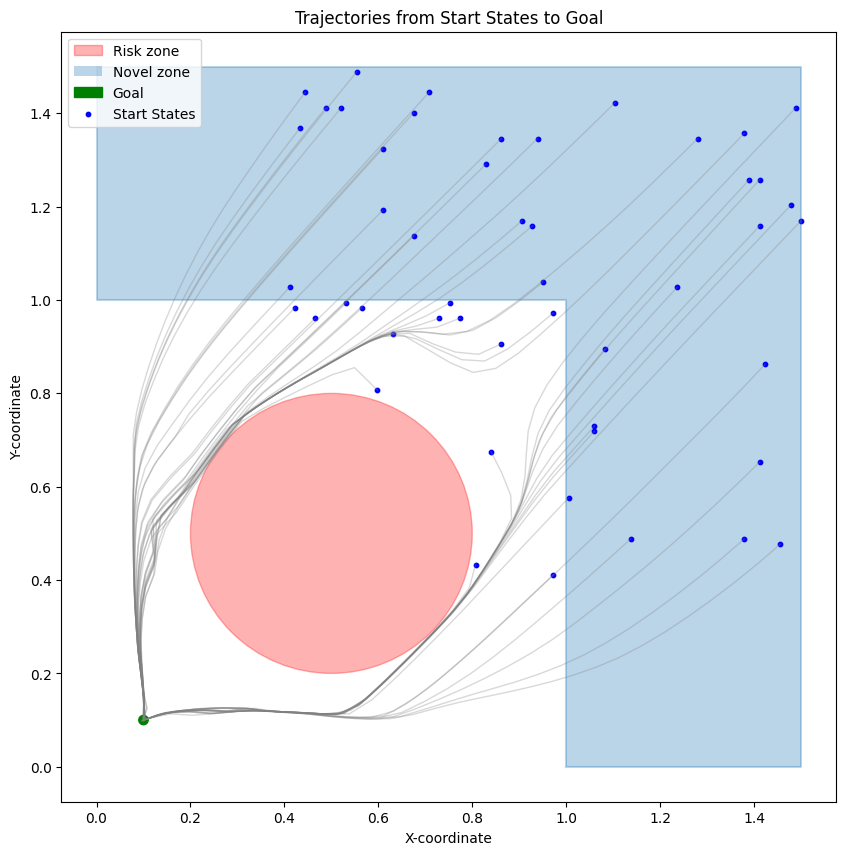

In [58]:
id_data = np.random.uniform(0, 1, (1000, 2))
mixed_policy = MixedPolicy(risky_policy, safe_policy, env.action_space, id_data)
plot_trajectories(mixed_policy)

In [10]:
def get_returns(policy, init_states, return_cede_ctrl=False):
    policy.eval()
    returns = []
    cede_ctrl = []
    novel = []
    risky = []
    for state in init_states:
        obs, info = env.reset(init_state=state)
        done = False
        cum_reward = 0
        actions = []
        if return_cede_ctrl:
            cctrl_ep = []
            novel_ep = []
            risky_ep = []
        while not done:
            batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(device), info=info)
            with torch.no_grad():
                result = policy(batch)
            act = result.act.cpu().squeeze().numpy()
            act = policy.map_action(act)
            if return_cede_ctrl:
                cctrl_ep.append(result.policy.cede_ctrl.cpu().squeeze().numpy())
                novel_ep.append(result.policy.novel.cpu().squeeze().numpy())
                risky_ep.append(result.policy.risky.cpu().squeeze().numpy())
            obs, reward, terminated, truncated, info = env.step(act)
            actions.append(act)
            cum_reward += reward
            done = terminated or truncated
        returns.append(cum_reward)
        if return_cede_ctrl:
            cede_ctrl.append(np.array(cctrl_ep).mean())
            novel.append(np.array(novel_ep).mean())
            risky.append(np.array(risky_ep).mean())
    if return_cede_ctrl:
        return np.array(returns),  np.array(cede_ctrl).mean(), np.array(novel).mean(), np.array(risky).mean()
    return np.array(returns)

In [51]:
init_states = get_init_states(500)

In [52]:
safe_returns = get_returns(safe_policy, init_states)

In [53]:
risky_returns = get_returns(risky_policy, init_states)

In [54]:
mixed_returns = get_returns(mixed_policy, init_states)

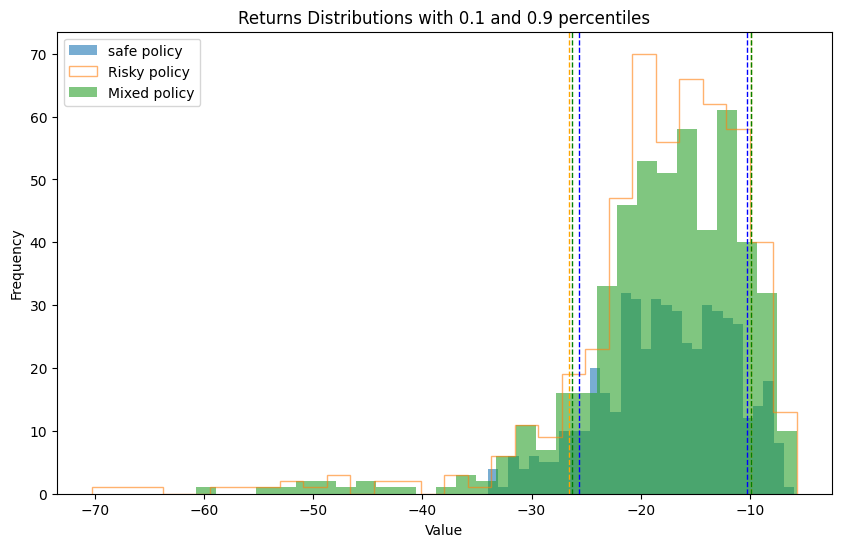

In [55]:
percentile_10_safe = np.percentile(safe_returns, 10)
percentile_90_safe = np.percentile(safe_returns, 90)
percentile_10_risky = np.percentile(risky_returns, 10)
percentile_90_risky = np.percentile(risky_returns, 90)
percentile_10_mixed = np.percentile(mixed_returns, 10)
percentile_90_mixed = np.percentile(mixed_returns, 90)

plt.figure(figsize=(10, 6))
# Histograms with different styles
plt.hist(safe_returns, bins=30, alpha=0.6, label='safe policy', histtype='stepfilled')
plt.hist(risky_returns, bins=30, alpha=0.6, label='Risky policy', histtype='step')
plt.hist(mixed_returns, bins=30, alpha=0.6, label='Mixed policy', histtype='barstacked')

# Percentile lines
plt.axvline(percentile_10_safe, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(percentile_90_safe, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(percentile_10_risky, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(percentile_90_risky, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(percentile_10_mixed, color='green', linestyle='dashed', linewidth=1)
plt.axvline(percentile_90_mixed, color='green', linestyle='dashed', linewidth=1)

# Titles and labels
plt.title('Returns Distributions with 0.1 and 0.9 percentiles')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [59]:
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
algo_name = "mixed"
log_name = os.path.join(task+f"_prob{risk_prob}"+f"_pen{risk_penalty}"+f"_hs{high_state}", algo_name, str(seed), now)
log_path = os.path.join(logdir, log_name)
print(f"log path: {log_path}")

# logger
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

log path: log/PointMass_prob0.95_pen20_hs1.5/mixed/0/240125-142048


In [11]:
init_states = get_init_states(100)

In [13]:
returns = []
for _ in range(20):
    returns.append(get_returns(safe_policy, init_states))

In [15]:
np.stack(returns)

array([[-21.2834706 , -20.75788773, -21.44481546, ...,  -7.52779885,
        -23.12954143, -17.16475031],
       [-21.2834706 , -20.75788773, -21.44481546, ...,  -7.52779885,
        -23.12954143, -17.16475031],
       [-21.2834706 , -20.75788773, -21.44481546, ...,  -7.52779885,
        -23.12954143, -17.16475031],
       ...,
       [-21.2834706 , -20.75788773, -21.44481546, ...,  -7.52779885,
        -23.12954143, -17.16475031],
       [-21.2834706 , -20.75788773, -21.44481546, ...,  -7.52779885,
        -23.12954143, -17.16475031],
       [-21.2834706 , -20.75788773, -21.44481546, ...,  -7.52779885,
        -23.12954143, -17.16475031]])

In [60]:
init_states = get_init_states(100)
safe_returns = get_returns(safe_policy, init_states)
def test_fn(num_epoch: int, step_idx: int):        
    returns, cede_ctrl, novel, risky = get_returns(mixed_policy, init_states, True)
    risky_returns = get_returns(risky_policy, init_states)
    percentile_10 = np.percentile(returns, 10)
    risky_percentile_10 = np.percentile(risky_returns, 10)
    safe_percentile_10 = np.percentile(safe_returns, 10)
    id_data = buffer.sample(5000)[0].obs
    mixed_policy.update_kde(id_data)
    print("Percentile 10: ", percentile_10, "Risky Percentile 10: ", risky_percentile_10, "Safe Percentile 10: ", safe_percentile_10, "Cede Control: ", cede_ctrl)
    # Log data to TensorBoard
    writer.add_scalar("Stats/Percentile 10", percentile_10, global_step=step_idx)
    writer.add_scalar("Stats/Risky Percentile 10", risky_percentile_10, global_step=step_idx)
    writer.add_scalar("Stats/Safe Percentile 10", safe_percentile_10, global_step=step_idx)
    writer.add_scalar("Stats/Cede Control", cede_ctrl, global_step=step_idx)
    writer.add_scalar("Stats/Novel", novel, global_step=step_idx)
    writer.add_scalar("Stats/Risky", risky, global_step=step_idx)

In [61]:
buffer = VectorReplayBuffer.load_hdf5("/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20/dsac/wang-0.75/0/240116-111416/buffer.hdf5")
train_collector = Collector(mixed_policy, train_envs, buffer)
test_buffer = VectorReplayBuffer(1000*test_num, test_num)
test_collector = Collector(mixed_policy, train_envs, test_buffer)

In [62]:
result = OffpolicyTrainer(
    policy=mixed_policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=epoch,
    step_per_epoch=step_per_epoch,
    step_per_collect=step_per_collect,
    episode_per_test=test_num,
    batch_size=batch_size,
    save_best_fn=save_best_fn,
    test_fn=test_fn,
    logger=logger,
    update_per_step=update_per_step,
    test_in_train=False,
).run()
pprint.pprint(result)

Percentile 10:  -24.248535445458504 Risky Percentile 10:  -39.11412040055255 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.841897470952159


Epoch #1: 501it [00:13, 37.33it/s, alpha=0.017, env_step=500, gradient_step=500, len=30, loss/actor=2.682, loss/alpha=-18.950, loss/critic1=0.129, loss/critic2=0.129, n/ep=0, n/st=1, rew=-15.72]                         


Percentile 10:  -24.517407411651657 Risky Percentile 10:  -33.86798346258093 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.5522064866637748
Epoch #1: test_reward: -14.378426 ± 7.861872, best_reward: -13.466904 ± 5.633409 in #0


Epoch #2: 501it [00:13, 37.40it/s, alpha=0.015, env_step=1000, gradient_step=1000, len=23, loss/actor=2.581, loss/alpha=-19.398, loss/critic1=0.111, loss/critic2=0.111, n/ep=0, n/st=1, rew=-11.18]                         


Percentile 10:  -24.11903426658909 Risky Percentile 10:  -31.852777712583755 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.4517753213583445
Epoch #2: test_reward: -13.055243 ± 8.378459, best_reward: -13.055243 ± 8.378459 in #2


Epoch #3: 501it [00:13, 36.64it/s, alpha=0.013, env_step=1500, gradient_step=1500, len=19, loss/actor=2.505, loss/alpha=-20.436, loss/critic1=0.106, loss/critic2=0.106, n/ep=0, n/st=1, rew=-7.49]                          


Percentile 10:  -24.212569987379343 Risky Percentile 10:  -28.73985508782587 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.41837320909336023
Epoch #3: test_reward: -17.616302 ± 7.414503, best_reward: -13.055243 ± 8.378459 in #2


Epoch #4: 501it [00:13, 36.55it/s, alpha=0.011, env_step=2000, gradient_step=2000, len=14, loss/actor=2.418, loss/alpha=-19.109, loss/critic1=0.093, loss/critic2=0.093, n/ep=0, n/st=1, rew=-2.21]                          


Percentile 10:  -24.071741375867834 Risky Percentile 10:  -27.01133945785639 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.43200061856996036
Epoch #4: test_reward: -14.154019 ± 4.707794, best_reward: -13.055243 ± 8.378459 in #2


Epoch #5: 501it [00:13, 36.50it/s, alpha=0.010, env_step=2500, gradient_step=2500, len=27, loss/actor=2.322, loss/alpha=-20.602, loss/critic1=0.089, loss/critic2=0.089, n/ep=0, n/st=1, rew=-17.89]                         


Percentile 10:  -24.25174719327375 Risky Percentile 10:  -27.333303537244223 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.3717768894764151
Epoch #5: test_reward: -11.997345 ± 8.165594, best_reward: -11.997345 ± 8.165594 in #5


Epoch #6: 501it [00:13, 37.03it/s, alpha=0.008, env_step=3000, gradient_step=3000, len=28, loss/actor=2.296, loss/alpha=-20.807, loss/critic1=0.086, loss/critic2=0.086, n/ep=0, n/st=1, rew=-20.78]                         


Percentile 10:  -25.329157637809676 Risky Percentile 10:  -28.56618089767174 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.3559592777173026
Epoch #6: test_reward: -11.664260 ± 4.096712, best_reward: -11.664260 ± 4.096712 in #6


Epoch #7: 501it [00:13, 37.07it/s, alpha=0.007, env_step=3500, gradient_step=3500, len=24, loss/actor=2.344, loss/alpha=-20.448, loss/critic1=0.083, loss/critic2=0.084, n/ep=0, n/st=1, rew=-14.66]                         


Percentile 10:  -23.989630918614232 Risky Percentile 10:  -28.47122486267642 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.33633330899665764
Epoch #7: test_reward: -10.238084 ± 6.777579, best_reward: -10.238084 ± 6.777579 in #7


Epoch #8: 501it [00:13, 36.44it/s, alpha=0.006, env_step=4000, gradient_step=4000, len=28, loss/actor=2.326, loss/alpha=-20.357, loss/critic1=0.079, loss/critic2=0.079, n/ep=0, n/st=1, rew=-22.04]                         


Percentile 10:  -24.42891178540266 Risky Percentile 10:  -30.57087679096268 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.3108188988689236
Epoch #8: test_reward: -15.367997 ± 5.504205, best_reward: -10.238084 ± 6.777579 in #7


Epoch #9: 501it [00:13, 36.44it/s, alpha=0.005, env_step=4500, gradient_step=4500, len=24, loss/actor=2.325, loss/alpha=-21.279, loss/critic1=0.085, loss/critic2=0.085, n/ep=0, n/st=1, rew=-16.03]                         


Percentile 10:  -25.200273292374995 Risky Percentile 10:  -27.587713318038855 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.3179700877139818
Epoch #9: test_reward: -9.912430 ± 6.188469, best_reward: -9.912430 ± 6.188469 in #9


Epoch #10: 501it [00:13, 36.71it/s, alpha=0.005, env_step=5000, gradient_step=5000, len=9, loss/actor=2.351, loss/alpha=-20.135, loss/critic1=0.076, loss/critic2=0.076, n/ep=0, n/st=1, rew=-1.61]                           


Percentile 10:  -24.297883685799572 Risky Percentile 10:  -26.92895809437402 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.3087404393978518
Epoch #10: test_reward: -12.372166 ± 2.680895, best_reward: -9.912430 ± 6.188469 in #9


Epoch #11: 501it [00:13, 36.94it/s, alpha=0.004, env_step=5500, gradient_step=5500, len=24, loss/actor=2.407, loss/alpha=-20.263, loss/critic1=0.073, loss/critic2=0.073, n/ep=0, n/st=1, rew=-14.65]                         


Percentile 10:  -24.49512638272093 Risky Percentile 10:  -27.335769845545503 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.2300571311403696
Epoch #11: test_reward: -11.801838 ± 8.009351, best_reward: -9.912430 ± 6.188469 in #9


Epoch #12: 501it [00:13, 36.92it/s, alpha=0.004, env_step=6000, gradient_step=6000, len=7, loss/actor=2.434, loss/alpha=-19.160, loss/critic1=0.071, loss/critic2=0.071, n/ep=0, n/st=1, rew=-0.65]                           


Percentile 10:  -24.437323077857787 Risky Percentile 10:  -25.636056053895146 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.23778990714575132
Epoch #12: test_reward: -11.084176 ± 7.384616, best_reward: -9.912430 ± 6.188469 in #9


Epoch #13: 501it [00:13, 36.88it/s, alpha=0.003, env_step=6500, gradient_step=6500, len=25, loss/actor=2.398, loss/alpha=-19.092, loss/critic1=0.062, loss/critic2=0.062, n/ep=0, n/st=1, rew=-15.84]                         


Percentile 10:  -24.845803875618486 Risky Percentile 10:  -28.635265016444674 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.20995231415784393
Epoch #13: test_reward: -14.398445 ± 6.632639, best_reward: -9.912430 ± 6.188469 in #9


Epoch #14: 501it [00:13, 37.10it/s, alpha=0.003, env_step=7000, gradient_step=7000, len=5, loss/actor=2.476, loss/alpha=-19.031, loss/critic1=0.074, loss/critic2=0.074, n/ep=0, n/st=1, rew=0.00]                            


Percentile 10:  -25.604884339312587 Risky Percentile 10:  -27.347940136771708 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.2935081711561778
Epoch #14: test_reward: -13.210761 ± 5.838470, best_reward: -9.912430 ± 6.188469 in #9


Epoch #15: 501it [00:13, 37.03it/s, alpha=0.002, env_step=7500, gradient_step=7500, len=31, loss/actor=2.498, loss/alpha=-18.697, loss/critic1=0.080, loss/critic2=0.080, n/ep=0, n/st=1, rew=-24.84]                         


Percentile 10:  -26.673115842812916 Risky Percentile 10:  -39.227590480206466 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.2944512868235593
Epoch #15: test_reward: -12.790114 ± 5.533997, best_reward: -9.912430 ± 6.188469 in #9


Epoch #16: 501it [00:13, 36.92it/s, alpha=0.002, env_step=8000, gradient_step=8000, len=27, loss/actor=2.498, loss/alpha=-18.887, loss/critic1=0.067, loss/critic2=0.068, n/ep=0, n/st=1, rew=-17.96]                         


Percentile 10:  -24.366279267442145 Risky Percentile 10:  -24.87947344471898 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.28977015852554744
Epoch #16: test_reward: -11.545714 ± 6.143603, best_reward: -9.912430 ± 6.188469 in #9


Epoch #17: 501it [00:13, 37.04it/s, alpha=0.002, env_step=8500, gradient_step=8500, len=21, loss/actor=2.493, loss/alpha=-18.143, loss/critic1=0.068, loss/critic2=0.068, n/ep=0, n/st=1, rew=-10.86]                         


Percentile 10:  -24.902695479910385 Risky Percentile 10:  -24.67016563033113 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.12936652384440048
Epoch #17: test_reward: -15.867362 ± 4.746212, best_reward: -9.912430 ± 6.188469 in #9


Epoch #18: 501it [00:13, 36.98it/s, alpha=0.002, env_step=9000, gradient_step=9000, len=26, loss/actor=2.555, loss/alpha=-16.631, loss/critic1=0.064, loss/critic2=0.064, n/ep=0, n/st=1, rew=-17.68]                         


Percentile 10:  -25.254771066627395 Risky Percentile 10:  -27.33858610592777 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.17561665391474612
Epoch #18: test_reward: -14.612289 ± 13.146160, best_reward: -9.912430 ± 6.188469 in #9


Epoch #19: 501it [00:13, 36.80it/s, alpha=0.001, env_step=9500, gradient_step=9500, len=28, loss/actor=2.547, loss/alpha=-16.050, loss/critic1=0.070, loss/critic2=0.070, n/ep=0, n/st=1, rew=-20.98]                         


Percentile 10:  -25.18848728987958 Risky Percentile 10:  -40.273453180200335 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.20094140272224773
Epoch #19: test_reward: -11.891052 ± 11.502058, best_reward: -9.912430 ± 6.188469 in #9


Epoch #20: 501it [00:13, 36.80it/s, alpha=0.001, env_step=10000, gradient_step=10000, len=25, loss/actor=2.510, loss/alpha=-15.725, loss/critic1=0.057, loss/critic2=0.057, n/ep=0, n/st=1, rew=-15.67]                         


Percentile 10:  -24.505246352678924 Risky Percentile 10:  -24.24077239793156 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.12058808045716812
Epoch #20: test_reward: -17.650461 ± 7.481875, best_reward: -9.912430 ± 6.188469 in #9


Epoch #21: 501it [00:13, 36.92it/s, alpha=0.001, env_step=10500, gradient_step=10500, len=17, loss/actor=2.578, loss/alpha=-15.181, loss/critic1=0.060, loss/critic2=0.060, n/ep=0, n/st=1, rew=-6.75]                          


Percentile 10:  -24.60649074350307 Risky Percentile 10:  -26.01425062798135 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.18151893221596754
Epoch #21: test_reward: -8.732301 ± 5.501214, best_reward: -8.732301 ± 5.501214 in #21


Epoch #22: 501it [00:13, 36.47it/s, alpha=0.001, env_step=11000, gradient_step=11000, len=16, loss/actor=2.645, loss/alpha=-15.006, loss/critic1=0.056, loss/critic2=0.056, n/ep=0, n/st=1, rew=-6.14]                          


Percentile 10:  -23.80214959359615 Risky Percentile 10:  -23.633867289570198 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.12159483952248827
Epoch #22: test_reward: -10.464677 ± 8.302293, best_reward: -8.732301 ± 5.501214 in #21


Epoch #23: 501it [00:13, 36.79it/s, alpha=0.001, env_step=11500, gradient_step=11500, len=21, loss/actor=2.651, loss/alpha=-13.229, loss/critic1=0.070, loss/critic2=0.070, n/ep=0, n/st=1, rew=-11.49]                         


Percentile 10:  -23.889859351393152 Risky Percentile 10:  -23.72844882584274 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.17461989501093522
Epoch #23: test_reward: -9.691004 ± 5.288127, best_reward: -8.732301 ± 5.501214 in #21


Epoch #24: 501it [00:13, 36.60it/s, alpha=0.001, env_step=12000, gradient_step=12000, len=14, loss/actor=2.621, loss/alpha=-13.651, loss/critic1=0.062, loss/critic2=0.062, n/ep=0, n/st=1, rew=-4.43]                          


Percentile 10:  -23.776476164822057 Risky Percentile 10:  -26.45336003105049 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.09057559748352094
Epoch #24: test_reward: -12.110692 ± 8.234834, best_reward: -8.732301 ± 5.501214 in #21


Epoch #25: 501it [00:13, 36.85it/s, alpha=0.001, env_step=12500, gradient_step=12500, len=25, loss/actor=2.632, loss/alpha=-11.943, loss/critic1=0.054, loss/critic2=0.054, n/ep=0, n/st=1, rew=-16.52]                         


Percentile 10:  -24.183761444935694 Risky Percentile 10:  -24.322541661922635 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.10584539548657215
Epoch #25: test_reward: -14.734967 ± 9.462633, best_reward: -8.732301 ± 5.501214 in #21


Epoch #26: 501it [00:13, 37.00it/s, alpha=0.001, env_step=13000, gradient_step=13000, len=19, loss/actor=2.654, loss/alpha=-9.726, loss/critic1=0.051, loss/critic2=0.051, n/ep=0, n/st=1, rew=-9.21]                           


Percentile 10:  -26.282781011534308 Risky Percentile 10:  -25.83453682478895 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.07467823884292232
Epoch #26: test_reward: -12.714386 ± 6.847957, best_reward: -8.732301 ± 5.501214 in #21


Epoch #27: 501it [00:13, 37.28it/s, alpha=0.000, env_step=13500, gradient_step=13500, len=22, loss/actor=2.670, loss/alpha=-11.475, loss/critic1=0.067, loss/critic2=0.067, n/ep=0, n/st=1, rew=-12.11]                         


Percentile 10:  -24.371058301142014 Risky Percentile 10:  -24.46839336911196 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.12932517925481077
Epoch #27: test_reward: -15.326724 ± 4.291566, best_reward: -8.732301 ± 5.501214 in #21


Epoch #28: 501it [00:13, 37.09it/s, alpha=0.000, env_step=14000, gradient_step=14000, len=32, loss/actor=2.710, loss/alpha=-10.764, loss/critic1=0.064, loss/critic2=0.064, n/ep=0, n/st=1, rew=-26.86]                         


Percentile 10:  -23.574575331762286 Risky Percentile 10:  -24.206616669324323 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.17643976558771066
Epoch #28: test_reward: -13.194136 ± 6.160875, best_reward: -8.732301 ± 5.501214 in #21


Epoch #29: 501it [00:13, 37.22it/s, alpha=0.000, env_step=14500, gradient_step=14500, len=33, loss/actor=2.752, loss/alpha=-9.824, loss/critic1=0.066, loss/critic2=0.066, n/ep=0, n/st=1, rew=-28.09]                          


Percentile 10:  -24.294375119469503 Risky Percentile 10:  -23.30533862292981 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.08536639493782479
Epoch #29: test_reward: -13.518206 ± 10.287019, best_reward: -8.732301 ± 5.501214 in #21


Epoch #30: 501it [00:13, 37.20it/s, alpha=0.000, env_step=15000, gradient_step=15000, len=14, loss/actor=2.688, loss/alpha=-6.087, loss/critic1=0.064, loss/critic2=0.064, n/ep=0, n/st=1, rew=-4.69]                           


Percentile 10:  -23.722341949726637 Risky Percentile 10:  -24.548764229857674 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.06761039577276824
Epoch #30: test_reward: -20.803937 ± 6.979343, best_reward: -8.732301 ± 5.501214 in #21


Epoch #31: 501it [00:13, 36.79it/s, alpha=0.000, env_step=15500, gradient_step=15500, len=12, loss/actor=2.737, loss/alpha=-5.708, loss/critic1=0.056, loss/critic2=0.057, n/ep=0, n/st=1, rew=-3.56]                          


Percentile 10:  -24.11441788861114 Risky Percentile 10:  -26.84214108194112 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.09701951277402916
Epoch #31: test_reward: -13.422434 ± 6.939579, best_reward: -8.732301 ± 5.501214 in #21


Epoch #32: 501it [00:13, 37.23it/s, alpha=0.000, env_step=16000, gradient_step=16000, len=12, loss/actor=2.721, loss/alpha=-5.411, loss/critic1=0.061, loss/critic2=0.061, n/ep=0, n/st=1, rew=-3.44]                          


Percentile 10:  -24.55388147921725 Risky Percentile 10:  -24.732541006080663 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.10619135730273252
Epoch #32: test_reward: -10.483463 ± 4.883234, best_reward: -8.732301 ± 5.501214 in #21


Epoch #33: 501it [00:13, 37.17it/s, alpha=0.000, env_step=16500, gradient_step=16500, len=8, loss/actor=2.781, loss/alpha=-7.663, loss/critic1=0.066, loss/critic2=0.066, n/ep=0, n/st=1, rew=-1.20]                           


Percentile 10:  -23.83165437140925 Risky Percentile 10:  -24.047562122867472 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.1752075262279875
Epoch #33: test_reward: -15.882623 ± 7.609802, best_reward: -8.732301 ± 5.501214 in #21


Epoch #34: 501it [00:13, 37.16it/s, alpha=0.000, env_step=17000, gradient_step=17000, len=32, loss/actor=2.768, loss/alpha=-4.111, loss/critic1=0.060, loss/critic2=0.060, n/ep=0, n/st=1, rew=-25.40]                         


Percentile 10:  -30.524700944113984 Risky Percentile 10:  -33.43697430637938 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.0645773098729022
Epoch #34: test_reward: -11.570877 ± 4.758707, best_reward: -8.732301 ± 5.501214 in #21


Epoch #35: 501it [00:13, 37.16it/s, alpha=0.000, env_step=17500, gradient_step=17500, len=28, loss/actor=2.818, loss/alpha=-0.419, loss/critic1=0.057, loss/critic2=0.057, n/ep=0, n/st=1, rew=-20.78]                         


Percentile 10:  -23.83129203804954 Risky Percentile 10:  -23.782936776718095 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.06472518921477736
Epoch #35: test_reward: -16.957789 ± 8.146298, best_reward: -8.732301 ± 5.501214 in #21


Epoch #36: 501it [00:13, 36.29it/s, alpha=0.000, env_step=18000, gradient_step=18000, len=11, loss/actor=2.795, loss/alpha=-1.964, loss/critic1=0.059, loss/critic2=0.059, n/ep=0, n/st=1, rew=-2.86]                          


Percentile 10:  -23.30637626502532 Risky Percentile 10:  -23.22472009040996 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.09818079059618044
Epoch #36: test_reward: -11.656061 ± 6.936258, best_reward: -8.732301 ± 5.501214 in #21


Epoch #37: 501it [00:14, 35.51it/s, alpha=0.000, env_step=18500, gradient_step=18500, len=26, loss/actor=2.814, loss/alpha=-1.412, loss/critic1=0.054, loss/critic2=0.054, n/ep=1, n/st=1, rew=-16.87]                         


Percentile 10:  -23.825338420309958 Risky Percentile 10:  -23.82458151817969 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.11212948208429718
Epoch #37: test_reward: -14.371720 ± 4.199607, best_reward: -8.732301 ± 5.501214 in #21


Epoch #38: 501it [00:14, 34.72it/s, alpha=0.000, env_step=19000, gradient_step=19000, len=24, loss/actor=2.850, loss/alpha=0.536, loss/critic1=0.052, loss/critic2=0.052, n/ep=0, n/st=1, rew=-14.77]                          


Percentile 10:  -23.570230885703538 Risky Percentile 10:  -24.62316706848731 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.059873232778379026
Epoch #38: test_reward: -15.299959 ± 5.001340, best_reward: -8.732301 ± 5.501214 in #21


Epoch #39: 501it [00:14, 35.79it/s, alpha=0.000, env_step=19500, gradient_step=19500, len=4, loss/actor=2.866, loss/alpha=0.876, loss/critic1=0.066, loss/critic2=0.066, n/ep=0, n/st=1, rew=0.33]                             


Percentile 10:  -23.786766233766198 Risky Percentile 10:  -24.168601231694232 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.11547170456597552
Epoch #39: test_reward: -10.910965 ± 7.349828, best_reward: -8.732301 ± 5.501214 in #21


Epoch #40: 501it [00:13, 36.86it/s, alpha=0.000, env_step=20000, gradient_step=20000, len=28, loss/actor=2.837, loss/alpha=-1.356, loss/critic1=0.066, loss/critic2=0.066, n/ep=0, n/st=1, rew=-18.68]                         


Percentile 10:  -23.65998842666413 Risky Percentile 10:  -23.801209143666014 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.10275429835609173
Epoch #40: test_reward: -12.329370 ± 6.783828, best_reward: -8.732301 ± 5.501214 in #21


Epoch #41: 501it [00:13, 36.46it/s, alpha=0.000, env_step=20500, gradient_step=20500, len=24, loss/actor=2.890, loss/alpha=3.692, loss/critic1=0.057, loss/critic2=0.058, n/ep=0, n/st=1, rew=-15.90]                          


Percentile 10:  -24.188799962461285 Risky Percentile 10:  -27.008409677028016 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.10526642746130095
Epoch #41: test_reward: -15.007351 ± 5.613733, best_reward: -8.732301 ± 5.501214 in #21


Epoch #42: 501it [00:13, 36.50it/s, alpha=0.000, env_step=21000, gradient_step=21000, len=23, loss/actor=2.846, loss/alpha=-1.693, loss/critic1=0.059, loss/critic2=0.059, n/ep=0, n/st=1, rew=-13.25]                         


Percentile 10:  -23.408881846504872 Risky Percentile 10:  -23.32673825631947 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.0827481305347764
Epoch #42: test_reward: -10.048601 ± 7.843885, best_reward: -8.732301 ± 5.501214 in #21


Epoch #43: 501it [00:13, 37.17it/s, alpha=0.000, env_step=21500, gradient_step=21500, len=17, loss/actor=2.922, loss/alpha=-3.880, loss/critic1=0.064, loss/critic2=0.064, n/ep=0, n/st=1, rew=-6.98]                          


Percentile 10:  -25.270333755177745 Risky Percentile 10:  -25.3179059969945 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.10327971732163198
Epoch #43: test_reward: -13.251415 ± 6.060583, best_reward: -8.732301 ± 5.501214 in #21


Epoch #44: 501it [00:13, 37.06it/s, alpha=0.000, env_step=22000, gradient_step=22000, len=8, loss/actor=2.955, loss/alpha=-5.102, loss/critic1=0.057, loss/critic2=0.057, n/ep=0, n/st=1, rew=-1.16]                           


Percentile 10:  -24.93121167966087 Risky Percentile 10:  -24.217177883953696 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.10021571345982527
Epoch #44: test_reward: -7.234823 ± 5.191333, best_reward: -7.234823 ± 5.191333 in #44


Epoch #45: 501it [00:13, 36.52it/s, alpha=0.000, env_step=22500, gradient_step=22500, len=15, loss/actor=2.952, loss/alpha=2.024, loss/critic1=0.055, loss/critic2=0.056, n/ep=0, n/st=1, rew=-5.75]                           


Percentile 10:  -23.637658166480406 Risky Percentile 10:  -23.298929418583306 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.13652587405711358
Epoch #45: test_reward: -11.826853 ± 4.768567, best_reward: -7.234823 ± 5.191333 in #44


Epoch #46: 501it [00:14, 35.74it/s, alpha=0.000, env_step=23000, gradient_step=23000, len=24, loss/actor=2.917, loss/alpha=2.402, loss/critic1=0.049, loss/critic2=0.049, n/ep=0, n/st=1, rew=-15.31]                          


Percentile 10:  -24.609216967062135 Risky Percentile 10:  -25.968098245512333 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.05597016286184971
Epoch #46: test_reward: -11.751762 ± 7.677146, best_reward: -7.234823 ± 5.191333 in #44


Epoch #47: 501it [00:13, 36.40it/s, alpha=0.000, env_step=23500, gradient_step=23500, len=19, loss/actor=2.957, loss/alpha=-1.535, loss/critic1=0.056, loss/critic2=0.056, n/ep=0, n/st=1, rew=-9.46]                          


Percentile 10:  -23.427256820905182 Risky Percentile 10:  -23.266154327759416 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.05117190240413593
Epoch #47: test_reward: -13.365817 ± 8.259124, best_reward: -7.234823 ± 5.191333 in #44


Epoch #48: 501it [00:13, 36.15it/s, alpha=0.000, env_step=24000, gradient_step=24000, len=24, loss/actor=2.942, loss/alpha=0.831, loss/critic1=0.053, loss/critic2=0.053, n/ep=0, n/st=1, rew=-14.50]                          


Percentile 10:  -23.80347018600031 Risky Percentile 10:  -24.48227800035606 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.04215995333076486
Epoch #48: test_reward: -13.539768 ± 4.583783, best_reward: -7.234823 ± 5.191333 in #44


Epoch #49: 501it [00:14, 35.70it/s, alpha=0.000, env_step=24500, gradient_step=24500, len=28, loss/actor=2.932, loss/alpha=2.050, loss/critic1=0.058, loss/critic2=0.058, n/ep=0, n/st=1, rew=-21.41]                          


Percentile 10:  -23.667086670228606 Risky Percentile 10:  -24.273799506346215 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.09355805634328423
Epoch #49: test_reward: -15.910831 ± 9.336397, best_reward: -7.234823 ± 5.191333 in #44


Epoch #50: 501it [00:13, 36.13it/s, alpha=0.000, env_step=25000, gradient_step=25000, len=20, loss/actor=2.961, loss/alpha=-0.807, loss/critic1=0.052, loss/critic2=0.052, n/ep=0, n/st=1, rew=-10.18]                         


Percentile 10:  -23.82401229635314 Risky Percentile 10:  -23.710886979522257 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.045942885200472065
Epoch #50: test_reward: -14.244759 ± 6.333875, best_reward: -7.234823 ± 5.191333 in #44


Epoch #51: 501it [00:13, 36.53it/s, alpha=0.000, env_step=25500, gradient_step=25500, len=28, loss/actor=3.010, loss/alpha=5.278, loss/critic1=0.052, loss/critic2=0.052, n/ep=0, n/st=1, rew=-20.29]                          


Percentile 10:  -26.572582336604995 Risky Percentile 10:  -23.377923829226933 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.0876759291968823
Epoch #51: test_reward: -15.364487 ± 10.216397, best_reward: -7.234823 ± 5.191333 in #44


Epoch #52: 501it [00:13, 36.27it/s, alpha=0.000, env_step=26000, gradient_step=26000, len=23, loss/actor=3.008, loss/alpha=1.700, loss/critic1=0.051, loss/critic2=0.051, n/ep=0, n/st=1, rew=-13.44]                          


Percentile 10:  -23.76022451867795 Risky Percentile 10:  -23.716460220340036 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.0482267720475075
Epoch #52: test_reward: -19.828535 ± 7.371164, best_reward: -7.234823 ± 5.191333 in #44


Epoch #53: 501it [00:13, 35.99it/s, alpha=0.000, env_step=26500, gradient_step=26500, len=23, loss/actor=3.073, loss/alpha=3.323, loss/critic1=0.052, loss/critic2=0.052, n/ep=0, n/st=1, rew=-13.37]                          


Percentile 10:  -23.74440259856029 Risky Percentile 10:  -23.688999001826488 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.06429194810394862
Epoch #53: test_reward: -12.612441 ± 6.072550, best_reward: -7.234823 ± 5.191333 in #44


Epoch #54: 501it [00:14, 35.02it/s, alpha=0.000, env_step=27000, gradient_step=27000, len=27, loss/actor=3.063, loss/alpha=-1.459, loss/critic1=0.055, loss/critic2=0.054, n/ep=0, n/st=1, rew=-17.45]                         


Percentile 10:  -25.21584562249804 Risky Percentile 10:  -25.9472314921305 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.042606822912384684
Epoch #54: test_reward: -14.968045 ± 4.605178, best_reward: -7.234823 ± 5.191333 in #44


Epoch #55: 501it [00:13, 36.57it/s, alpha=0.000, env_step=27500, gradient_step=27500, len=23, loss/actor=3.045, loss/alpha=-2.008, loss/critic1=0.056, loss/critic2=0.056, n/ep=0, n/st=1, rew=-13.74]                         


Percentile 10:  -23.606606411808983 Risky Percentile 10:  -23.48436934507325 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.15831737271926255
Epoch #55: test_reward: -13.631550 ± 9.703982, best_reward: -7.234823 ± 5.191333 in #44


Epoch #56: 501it [00:13, 36.20it/s, alpha=0.000, env_step=28000, gradient_step=28000, len=31, loss/actor=3.021, loss/alpha=-2.635, loss/critic1=0.050, loss/critic2=0.050, n/ep=0, n/st=1, rew=-25.86]                         


Percentile 10:  -23.929417637889767 Risky Percentile 10:  -23.598508515450305 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.08893150925072323
Epoch #56: test_reward: -13.388605 ± 5.276291, best_reward: -7.234823 ± 5.191333 in #44


Epoch #57: 501it [00:13, 35.85it/s, alpha=0.000, env_step=28500, gradient_step=28500, len=24, loss/actor=3.087, loss/alpha=-1.425, loss/critic1=0.048, loss/critic2=0.048, n/ep=0, n/st=1, rew=-14.55]                         


Percentile 10:  -23.717216181004723 Risky Percentile 10:  -23.64164632882776 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.07424163377031948
Epoch #57: test_reward: -11.439238 ± 6.119608, best_reward: -7.234823 ± 5.191333 in #44


Epoch #58: 501it [00:13, 36.33it/s, alpha=0.000, env_step=29000, gradient_step=29000, len=32, loss/actor=3.120, loss/alpha=-1.629, loss/critic1=0.058, loss/critic2=0.058, n/ep=0, n/st=1, rew=-26.71]                         


Percentile 10:  -24.43439395325636 Risky Percentile 10:  -24.339699164702367 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.06862726826209312
Epoch #58: test_reward: -11.597368 ± 7.805289, best_reward: -7.234823 ± 5.191333 in #44


Epoch #59: 501it [00:13, 36.88it/s, alpha=0.000, env_step=29500, gradient_step=29500, len=23, loss/actor=3.187, loss/alpha=-0.588, loss/critic1=0.052, loss/critic2=0.052, n/ep=0, n/st=1, rew=-13.49]                         


Percentile 10:  -24.264075089034847 Risky Percentile 10:  -24.177579342484318 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.06312743303165753
Epoch #59: test_reward: -16.535758 ± 5.851791, best_reward: -7.234823 ± 5.191333 in #44


Epoch #60: 501it [00:13, 36.78it/s, alpha=0.000, env_step=30000, gradient_step=30000, len=25, loss/actor=3.152, loss/alpha=1.569, loss/critic1=0.051, loss/critic2=0.051, n/ep=0, n/st=1, rew=-17.30]                          


Percentile 10:  -24.854143160263614 Risky Percentile 10:  -24.67366766883219 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.1062505626405093
Epoch #60: test_reward: -13.558622 ± 7.076081, best_reward: -7.234823 ± 5.191333 in #44


Epoch #61: 501it [00:13, 36.48it/s, alpha=0.000, env_step=30500, gradient_step=30500, len=27, loss/actor=3.178, loss/alpha=-2.426, loss/critic1=0.055, loss/critic2=0.055, n/ep=0, n/st=1, rew=-18.84]                         


Percentile 10:  -24.307714325088398 Risky Percentile 10:  -24.209557424653333 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.09052510506895825
Epoch #61: test_reward: -13.212451 ± 10.381126, best_reward: -7.234823 ± 5.191333 in #44


Epoch #62: 501it [00:13, 36.50it/s, alpha=0.000, env_step=31000, gradient_step=31000, len=26, loss/actor=3.155, loss/alpha=-1.954, loss/critic1=0.059, loss/critic2=0.059, n/ep=0, n/st=1, rew=-18.07]                         


Percentile 10:  -23.86041090581167 Risky Percentile 10:  -23.822790525490788 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.07226437214122577
Epoch #62: test_reward: -14.830813 ± 6.842424, best_reward: -7.234823 ± 5.191333 in #44


Epoch #63: 501it [00:13, 36.71it/s, alpha=0.000, env_step=31500, gradient_step=31500, len=11, loss/actor=3.157, loss/alpha=-2.486, loss/critic1=0.055, loss/critic2=0.055, n/ep=0, n/st=1, rew=-2.98]                          


Percentile 10:  -24.014126207649777 Risky Percentile 10:  -23.970635831341834 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.07211340090134705
Epoch #63: test_reward: -11.335559 ± 4.945843, best_reward: -7.234823 ± 5.191333 in #44


Epoch #64: 501it [00:13, 36.16it/s, alpha=0.000, env_step=32000, gradient_step=32000, len=19, loss/actor=3.108, loss/alpha=1.826, loss/critic1=0.047, loss/critic2=0.047, n/ep=0, n/st=1, rew=-9.25]                           


Percentile 10:  -23.5509850238761 Risky Percentile 10:  -23.372811884412982 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.07302158596345809
Epoch #64: test_reward: -15.235300 ± 5.358392, best_reward: -7.234823 ± 5.191333 in #44


Epoch #65: 501it [00:13, 36.14it/s, alpha=0.000, env_step=32500, gradient_step=32500, len=29, loss/actor=3.167, loss/alpha=-6.053, loss/critic1=0.052, loss/critic2=0.052, n/ep=0, n/st=1, rew=-20.94]                         


Percentile 10:  -29.247195459819082 Risky Percentile 10:  -26.66781456233644 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.036324581229269445
Epoch #65: test_reward: -12.387355 ± 8.019179, best_reward: -7.234823 ± 5.191333 in #44


Epoch #66: 501it [00:13, 36.58it/s, alpha=0.000, env_step=33000, gradient_step=33000, len=20, loss/actor=3.205, loss/alpha=1.970, loss/critic1=0.052, loss/critic2=0.052, n/ep=0, n/st=1, rew=-10.30]                          


Percentile 10:  -23.69854763533439 Risky Percentile 10:  -23.72620764649612 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.046324451967916964
Epoch #66: test_reward: -14.371968 ± 5.929569, best_reward: -7.234823 ± 5.191333 in #44


Epoch #67: 501it [00:13, 36.46it/s, alpha=0.000, env_step=33500, gradient_step=33500, len=24, loss/actor=3.185, loss/alpha=-1.661, loss/critic1=0.048, loss/critic2=0.048, n/ep=0, n/st=1, rew=-14.72]                         


Percentile 10:  -23.395463697881276 Risky Percentile 10:  -23.321625239621003 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.030967490108943098
Epoch #67: test_reward: -13.141837 ± 9.450801, best_reward: -7.234823 ± 5.191333 in #44


Epoch #68: 501it [00:13, 37.06it/s, alpha=0.000, env_step=34000, gradient_step=34000, len=25, loss/actor=3.173, loss/alpha=2.413, loss/critic1=0.042, loss/critic2=0.042, n/ep=0, n/st=1, rew=-16.51]                          


Percentile 10:  -23.696945234001653 Risky Percentile 10:  -23.853334336254985 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.07597521549565323
Epoch #68: test_reward: -12.872393 ± 9.231456, best_reward: -7.234823 ± 5.191333 in #44


Epoch #69: 501it [00:13, 36.47it/s, alpha=0.000, env_step=34500, gradient_step=34500, len=19, loss/actor=3.183, loss/alpha=0.634, loss/critic1=0.046, loss/critic2=0.046, n/ep=0, n/st=1, rew=-9.62]                          


Percentile 10:  -23.715966512057793 Risky Percentile 10:  -24.704812866984106 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.055127291866379456
Epoch #69: test_reward: -11.527374 ± 6.145081, best_reward: -7.234823 ± 5.191333 in #44


Epoch #70: 501it [00:14, 35.11it/s, alpha=0.000, env_step=35000, gradient_step=35000, len=18, loss/actor=3.275, loss/alpha=0.746, loss/critic1=0.054, loss/critic2=0.054, n/ep=0, n/st=1, rew=-8.66]                           


Percentile 10:  -23.756323540410044 Risky Percentile 10:  -23.64823371624486 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.07472972597749865
Epoch #70: test_reward: -11.087314 ± 9.336858, best_reward: -7.234823 ± 5.191333 in #44


Epoch #71: 501it [00:13, 37.80it/s, alpha=0.000, env_step=35500, gradient_step=35500, len=20, loss/actor=3.212, loss/alpha=2.451, loss/critic1=0.048, loss/critic2=0.048, n/ep=0, n/st=1, rew=-10.36]                          


Percentile 10:  -23.399316175092636 Risky Percentile 10:  -23.29992833665406 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.07157384886598898
Epoch #71: test_reward: -15.902904 ± 7.311363, best_reward: -7.234823 ± 5.191333 in #44


Epoch #72: 501it [00:13, 37.77it/s, alpha=0.000, env_step=36000, gradient_step=36000, len=19, loss/actor=3.199, loss/alpha=2.852, loss/critic1=0.049, loss/critic2=0.049, n/ep=0, n/st=1, rew=-9.38]                           


Percentile 10:  -24.319435368925628 Risky Percentile 10:  -27.953258473857307 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.05293536953970448
Epoch #72: test_reward: -20.145669 ± 9.082337, best_reward: -7.234823 ± 5.191333 in #44


Epoch #73: 501it [00:13, 37.79it/s, alpha=0.000, env_step=36500, gradient_step=36500, len=4, loss/actor=3.210, loss/alpha=3.489, loss/critic1=0.048, loss/critic2=0.048, n/ep=0, n/st=1, rew=0.33]                            


Percentile 10:  -23.483014289412868 Risky Percentile 10:  -23.766538766240753 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.028162082221906862
Epoch #73: test_reward: -10.966993 ± 6.350989, best_reward: -7.234823 ± 5.191333 in #44


Epoch #74: 501it [00:13, 37.78it/s, alpha=0.000, env_step=37000, gradient_step=37000, len=25, loss/actor=3.267, loss/alpha=1.623, loss/critic1=0.058, loss/critic2=0.058, n/ep=0, n/st=1, rew=-16.19]                          


Percentile 10:  -23.64563195927286 Risky Percentile 10:  -24.34393229695114 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.07078376126664647
Epoch #74: test_reward: -19.422742 ± 9.995002, best_reward: -7.234823 ± 5.191333 in #44


Epoch #75: 501it [00:13, 37.77it/s, alpha=0.000, env_step=37500, gradient_step=37500, len=26, loss/actor=3.241, loss/alpha=-1.180, loss/critic1=0.042, loss/critic2=0.042, n/ep=0, n/st=1, rew=-18.03]                         


Percentile 10:  -23.900006451808096 Risky Percentile 10:  -23.788817834957936 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.098893514559795
Epoch #75: test_reward: -16.997791 ± 8.449985, best_reward: -7.234823 ± 5.191333 in #44


Epoch #76: 501it [00:13, 37.71it/s, alpha=0.000, env_step=38000, gradient_step=38000, len=21, loss/actor=3.246, loss/alpha=-1.819, loss/critic1=0.048, loss/critic2=0.048, n/ep=0, n/st=1, rew=-11.90]                         


Percentile 10:  -24.820570380181127 Risky Percentile 10:  -23.876032313707615 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.047932203688406665
Epoch #76: test_reward: -16.007377 ± 5.214545, best_reward: -7.234823 ± 5.191333 in #44


Epoch #77: 501it [00:13, 37.70it/s, alpha=0.000, env_step=38500, gradient_step=38500, len=26, loss/actor=3.258, loss/alpha=-0.934, loss/critic1=0.049, loss/critic2=0.049, n/ep=0, n/st=1, rew=-16.84]                         


Percentile 10:  -23.512500067783765 Risky Percentile 10:  -23.49974056084888 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.03859051139283505
Epoch #77: test_reward: -10.775034 ± 6.816729, best_reward: -7.234823 ± 5.191333 in #44


Epoch #78: 501it [00:14, 35.70it/s, alpha=0.000, env_step=39000, gradient_step=39000, len=27, loss/actor=3.209, loss/alpha=-1.748, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=-18.49]                         


Percentile 10:  -23.47637390207963 Risky Percentile 10:  -23.289642159280707 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.1356026395961909
Epoch #78: test_reward: -14.210905 ± 4.050071, best_reward: -7.234823 ± 5.191333 in #44


Epoch #79: 501it [00:13, 37.27it/s, alpha=0.000, env_step=39500, gradient_step=39500, len=27, loss/actor=3.303, loss/alpha=0.672, loss/critic1=0.042, loss/critic2=0.042, n/ep=0, n/st=1, rew=-20.90]                          


Percentile 10:  -23.58284598771227 Risky Percentile 10:  -23.56819785455962 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.06217878390505351
Epoch #79: test_reward: -14.579450 ± 8.822620, best_reward: -7.234823 ± 5.191333 in #44


Epoch #80: 501it [00:13, 37.30it/s, alpha=0.000, env_step=40000, gradient_step=40000, len=3, loss/actor=3.316, loss/alpha=-1.341, loss/critic1=0.050, loss/critic2=0.050, n/ep=0, n/st=1, rew=0.54]                            


Percentile 10:  -23.38603008184809 Risky Percentile 10:  -23.343684097885134 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.027941011705577723
Epoch #80: test_reward: -12.886418 ± 8.374005, best_reward: -7.234823 ± 5.191333 in #44


Epoch #81: 501it [00:13, 37.02it/s, alpha=0.000, env_step=40500, gradient_step=40500, len=21, loss/actor=3.319, loss/alpha=-2.597, loss/critic1=0.051, loss/critic2=0.051, n/ep=0, n/st=1, rew=-10.88]                         


Percentile 10:  -23.867804598567258 Risky Percentile 10:  -23.838428172160548 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.04302764936110783
Epoch #81: test_reward: -11.885430 ± 8.917569, best_reward: -7.234823 ± 5.191333 in #44


Epoch #82: 501it [00:13, 36.63it/s, alpha=0.000, env_step=41000, gradient_step=41000, len=18, loss/actor=3.260, loss/alpha=-0.861, loss/critic1=0.044, loss/critic2=0.045, n/ep=0, n/st=1, rew=-7.83]                          


Percentile 10:  -24.158387143402525 Risky Percentile 10:  -23.98901058793636 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.04706631857292476
Epoch #82: test_reward: -12.371099 ± 10.715564, best_reward: -7.234823 ± 5.191333 in #44


Epoch #83: 501it [00:14, 34.72it/s, alpha=0.000, env_step=41500, gradient_step=41500, len=28, loss/actor=3.295, loss/alpha=1.457, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-20.40]                          


Percentile 10:  -26.55092929835288 Risky Percentile 10:  -24.283992317480475 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.055268828393625145
Epoch #83: test_reward: -7.274800 ± 6.774596, best_reward: -7.234823 ± 5.191333 in #44


Epoch #84: 501it [00:13, 37.47it/s, alpha=0.000, env_step=42000, gradient_step=42000, len=27, loss/actor=3.355, loss/alpha=0.659, loss/critic1=0.054, loss/critic2=0.054, n/ep=0, n/st=1, rew=-17.72]                          


Percentile 10:  -24.1072496525996 Risky Percentile 10:  -23.863156083573788 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.030927374057180868
Epoch #84: test_reward: -9.080961 ± 6.711255, best_reward: -7.234823 ± 5.191333 in #44


Epoch #85: 501it [00:13, 36.70it/s, alpha=0.000, env_step=42500, gradient_step=42500, len=25, loss/actor=3.348, loss/alpha=-3.455, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-15.95]                         


Percentile 10:  -23.384873603188044 Risky Percentile 10:  -23.32362928608389 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.027069893950317458
Epoch #85: test_reward: -14.013824 ± 4.145135, best_reward: -7.234823 ± 5.191333 in #44


Epoch #86: 501it [00:13, 36.85it/s, alpha=0.000, env_step=43000, gradient_step=43000, len=18, loss/actor=3.346, loss/alpha=1.194, loss/critic1=0.041, loss/critic2=0.041, n/ep=0, n/st=1, rew=-8.51]                           


Percentile 10:  -23.527852427248867 Risky Percentile 10:  -23.481763105042692 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.06479392900496551
Epoch #86: test_reward: -14.413645 ± 8.702749, best_reward: -7.234823 ± 5.191333 in #44


Epoch #87: 501it [00:13, 37.41it/s, alpha=0.000, env_step=43500, gradient_step=43500, len=24, loss/actor=3.314, loss/alpha=1.898, loss/critic1=0.046, loss/critic2=0.046, n/ep=0, n/st=1, rew=-14.36]                          


Percentile 10:  -23.79190290984089 Risky Percentile 10:  -23.74973988805435 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.03217914050290384
Epoch #87: test_reward: -14.794509 ± 8.246477, best_reward: -7.234823 ± 5.191333 in #44


Epoch #88: 501it [00:13, 36.63it/s, alpha=0.000, env_step=44000, gradient_step=44000, len=21, loss/actor=3.395, loss/alpha=-1.705, loss/critic1=0.048, loss/critic2=0.048, n/ep=0, n/st=1, rew=-10.92]                         


Percentile 10:  -24.356355264219136 Risky Percentile 10:  -24.42853889807534 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.06010582868033096
Epoch #88: test_reward: -19.805741 ± 8.217202, best_reward: -7.234823 ± 5.191333 in #44


Epoch #89: 501it [00:13, 37.45it/s, alpha=0.000, env_step=44500, gradient_step=44500, len=24, loss/actor=3.420, loss/alpha=-1.728, loss/critic1=0.049, loss/critic2=0.049, n/ep=0, n/st=1, rew=-14.89]                         


Percentile 10:  -24.78727223605458 Risky Percentile 10:  -24.991101214102418 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.035409704767789214
Epoch #89: test_reward: -13.333481 ± 9.343142, best_reward: -7.234823 ± 5.191333 in #44


Epoch #90: 501it [00:13, 36.50it/s, alpha=0.000, env_step=45000, gradient_step=45000, len=20, loss/actor=3.407, loss/alpha=-2.145, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-10.74]                         


Percentile 10:  -25.081989893472702 Risky Percentile 10:  -24.270230674177544 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.05018476361303541
Epoch #90: test_reward: -8.235772 ± 6.681279, best_reward: -7.234823 ± 5.191333 in #44


Epoch #91: 501it [00:14, 35.62it/s, alpha=0.000, env_step=45500, gradient_step=45500, len=23, loss/actor=3.448, loss/alpha=-2.593, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-13.73]                         


Percentile 10:  -23.435062848125252 Risky Percentile 10:  -23.3502785913809 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.032397229975042
Epoch #91: test_reward: -13.311755 ± 7.814060, best_reward: -7.234823 ± 5.191333 in #44


Epoch #92: 501it [00:13, 37.39it/s, alpha=0.000, env_step=46000, gradient_step=46000, len=32, loss/actor=3.405, loss/alpha=-1.099, loss/critic1=0.040, loss/critic2=0.040, n/ep=0, n/st=1, rew=-27.47]                         


Percentile 10:  -23.361254835155684 Risky Percentile 10:  -23.298900595281268 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.03100594291342348
Epoch #92: test_reward: -12.766434 ± 5.026079, best_reward: -7.234823 ± 5.191333 in #44


Epoch #93: 501it [00:13, 36.44it/s, alpha=0.000, env_step=46500, gradient_step=46500, len=37, loss/actor=3.427, loss/alpha=-0.106, loss/critic1=0.046, loss/critic2=0.046, n/ep=0, n/st=1, rew=-34.06]                         


Percentile 10:  -23.39524311363144 Risky Percentile 10:  -23.55017644923781 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.04880858497227027
Epoch #93: test_reward: -14.793918 ± 8.100034, best_reward: -7.234823 ± 5.191333 in #44


Epoch #94: 501it [00:13, 37.25it/s, alpha=0.000, env_step=47000, gradient_step=47000, len=27, loss/actor=3.484, loss/alpha=-3.590, loss/critic1=0.049, loss/critic2=0.049, n/ep=0, n/st=1, rew=-18.93]                         


Percentile 10:  -23.948304048498592 Risky Percentile 10:  -23.760372493675035 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.03719460788539016
Epoch #94: test_reward: -13.614408 ± 7.290774, best_reward: -7.234823 ± 5.191333 in #44


Epoch #95: 501it [00:13, 36.13it/s, alpha=0.000, env_step=47500, gradient_step=47500, len=25, loss/actor=3.433, loss/alpha=-2.194, loss/critic1=0.039, loss/critic2=0.040, n/ep=0, n/st=1, rew=-16.12]                         


Percentile 10:  -26.09785259666035 Risky Percentile 10:  -24.99178617399792 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.034239031394061564
Epoch #95: test_reward: -13.092514 ± 7.311635, best_reward: -7.234823 ± 5.191333 in #44


Epoch #96: 501it [00:13, 36.98it/s, alpha=0.000, env_step=48000, gradient_step=48000, len=29, loss/actor=3.408, loss/alpha=3.352, loss/critic1=0.047, loss/critic2=0.047, n/ep=0, n/st=1, rew=-21.09]                         


Percentile 10:  -23.43119245885669 Risky Percentile 10:  -23.35143653436434 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.058394083886064714
Epoch #96: test_reward: -12.978281 ± 6.953973, best_reward: -7.234823 ± 5.191333 in #44


Epoch #97: 501it [00:13, 37.72it/s, alpha=0.000, env_step=48500, gradient_step=48500, len=3, loss/actor=3.461, loss/alpha=0.017, loss/critic1=0.040, loss/critic2=0.040, n/ep=1, n/st=1, rew=0.56]                             


Percentile 10:  -23.97975930341413 Risky Percentile 10:  -23.924073275848325 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.03905501720368566
Epoch #97: test_reward: -12.261613 ± 7.385743, best_reward: -7.234823 ± 5.191333 in #44


Epoch #98: 501it [00:14, 34.87it/s, alpha=0.000, env_step=49000, gradient_step=49000, len=19, loss/actor=3.454, loss/alpha=0.153, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=-9.15]                           


Percentile 10:  -23.62513834275764 Risky Percentile 10:  -23.527416008078156 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.030151859203839382
Epoch #98: test_reward: -14.983263 ± 3.838535, best_reward: -7.234823 ± 5.191333 in #44


Epoch #99: 501it [00:15, 33.20it/s, alpha=0.000, env_step=49500, gradient_step=49500, len=21, loss/actor=3.443, loss/alpha=2.983, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-11.50]                         


Percentile 10:  -23.442087488789902 Risky Percentile 10:  -23.419895609163028 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.029765653017377457
Epoch #99: test_reward: -15.679548 ± 7.509607, best_reward: -7.234823 ± 5.191333 in #44


Epoch #100: 501it [00:15, 31.53it/s, alpha=0.000, env_step=50000, gradient_step=50000, len=22, loss/actor=3.474, loss/alpha=-1.398, loss/critic1=0.038, loss/critic2=0.039, n/ep=1, n/st=1, rew=-12.62]                         


Percentile 10:  -23.27847078133204 Risky Percentile 10:  -23.202983103086332 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.01700385896274547
Epoch #100: test_reward: -13.388816 ± 6.661192, best_reward: -7.234823 ± 5.191333 in #44


Epoch #101: 501it [00:16, 30.92it/s, alpha=0.000, env_step=50500, gradient_step=50500, len=26, loss/actor=3.481, loss/alpha=-0.221, loss/critic1=0.039, loss/critic2=0.040, n/ep=0, n/st=1, rew=-18.24]                         


Percentile 10:  -24.096341403554206 Risky Percentile 10:  -24.184181548619726 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.05936872293942457
Epoch #101: test_reward: -9.677965 ± 5.197970, best_reward: -7.234823 ± 5.191333 in #44


Epoch #102: 501it [00:13, 37.68it/s, alpha=0.000, env_step=51000, gradient_step=51000, len=26, loss/actor=3.444, loss/alpha=-0.320, loss/critic1=0.044, loss/critic2=0.044, n/ep=0, n/st=1, rew=-17.19]                         


Percentile 10:  -23.276887444018882 Risky Percentile 10:  -23.23406447560547 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.03070506667801047
Epoch #102: test_reward: -12.296729 ± 9.460192, best_reward: -7.234823 ± 5.191333 in #44


Epoch #103: 501it [00:13, 37.68it/s, alpha=0.000, env_step=51500, gradient_step=51500, len=19, loss/actor=3.456, loss/alpha=0.221, loss/critic1=0.050, loss/critic2=0.050, n/ep=0, n/st=1, rew=-9.49]                           


Percentile 10:  -23.98089735522304 Risky Percentile 10:  -23.752027461600125 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.04059539708745774
Epoch #103: test_reward: -7.862311 ± 7.548779, best_reward: -7.234823 ± 5.191333 in #44


Epoch #104: 501it [00:13, 37.76it/s, alpha=0.000, env_step=52000, gradient_step=52000, len=20, loss/actor=3.448, loss/alpha=1.122, loss/critic1=0.047, loss/critic2=0.046, n/ep=0, n/st=1, rew=-10.19]                          


Percentile 10:  -23.52537510422134 Risky Percentile 10:  -23.414447530012467 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.04259699803706714
Epoch #104: test_reward: -14.188837 ± 8.493353, best_reward: -7.234823 ± 5.191333 in #44


Epoch #105: 501it [00:14, 34.91it/s, alpha=0.000, env_step=52500, gradient_step=52500, len=24, loss/actor=3.478, loss/alpha=1.946, loss/critic1=0.048, loss/critic2=0.048, n/ep=0, n/st=1, rew=-15.76]                          


Percentile 10:  -24.024248980045936 Risky Percentile 10:  -23.912196273111455 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.04323979629791452
Epoch #105: test_reward: -14.213727 ± 5.794784, best_reward: -7.234823 ± 5.191333 in #44


Epoch #106: 501it [00:14, 33.85it/s, alpha=0.000, env_step=53000, gradient_step=53000, len=6, loss/actor=3.490, loss/alpha=0.478, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=-0.26]                            


Percentile 10:  -23.776775331435868 Risky Percentile 10:  -24.193883270150803 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.034986139203594904
Epoch #106: test_reward: -10.158565 ± 6.774682, best_reward: -7.234823 ± 5.191333 in #44


Epoch #107: 501it [00:16, 31.06it/s, alpha=0.000, env_step=53500, gradient_step=53500, len=27, loss/actor=3.534, loss/alpha=1.775, loss/critic1=0.047, loss/critic2=0.047, n/ep=0, n/st=1, rew=-18.77]                          


Percentile 10:  -23.523192781596784 Risky Percentile 10:  -23.486451847525544 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.02630949019209832
Epoch #107: test_reward: -11.096260 ± 7.607881, best_reward: -7.234823 ± 5.191333 in #44


Epoch #108: 501it [00:16, 30.83it/s, alpha=0.000, env_step=54000, gradient_step=54000, len=21, loss/actor=3.504, loss/alpha=0.692, loss/critic1=0.038, loss/critic2=0.039, n/ep=0, n/st=1, rew=-11.28]                          


Percentile 10:  -23.523363005995606 Risky Percentile 10:  -23.45927526177541 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.03224200485988506
Epoch #108: test_reward: -17.787319 ± 5.685819, best_reward: -7.234823 ± 5.191333 in #44


Epoch #109: 501it [00:16, 30.53it/s, alpha=0.000, env_step=54500, gradient_step=54500, len=23, loss/actor=3.497, loss/alpha=1.183, loss/critic1=0.037, loss/critic2=0.037, n/ep=0, n/st=1, rew=-13.24]                          


Percentile 10:  -23.513258117714887 Risky Percentile 10:  -23.406813739597403 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.0370416498417359
Epoch #109: test_reward: -8.526110 ± 5.177205, best_reward: -7.234823 ± 5.191333 in #44


Epoch #110: 501it [00:13, 36.08it/s, alpha=0.000, env_step=55000, gradient_step=55000, len=25, loss/actor=3.559, loss/alpha=1.594, loss/critic1=0.044, loss/critic2=0.044, n/ep=0, n/st=1, rew=-16.07]                          


Percentile 10:  -23.523907896384006 Risky Percentile 10:  -23.414057312723074 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.03036399716005194
Epoch #110: test_reward: -15.638189 ± 11.707646, best_reward: -7.234823 ± 5.191333 in #44


Epoch #111: 501it [00:13, 36.27it/s, alpha=0.000, env_step=55500, gradient_step=55500, len=28, loss/actor=3.518, loss/alpha=-0.517, loss/critic1=0.047, loss/critic2=0.047, n/ep=0, n/st=1, rew=-21.13]                         


Percentile 10:  -23.389721104840504 Risky Percentile 10:  -23.382238526919956 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.027966031689816283
Epoch #111: test_reward: -16.009125 ± 7.400503, best_reward: -7.234823 ± 5.191333 in #44


Epoch #112: 501it [00:15, 32.42it/s, alpha=0.000, env_step=56000, gradient_step=56000, len=21, loss/actor=3.480, loss/alpha=0.244, loss/critic1=0.037, loss/critic2=0.037, n/ep=0, n/st=1, rew=-11.70]                          


Percentile 10:  -24.68240709595482 Risky Percentile 10:  -28.065297390998197 Safe Percentile 10:  -24.316957991311615 Cede Control:  0.04322663300262144
Epoch #112: test_reward: -12.712177 ± 8.659894, best_reward: -7.234823 ± 5.191333 in #44


Epoch #113: 501it [00:15, 32.62it/s, alpha=0.000, env_step=56500, gradient_step=56500, len=10, loss/actor=3.478, loss/alpha=0.815, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=-2.15]                           


KeyboardInterrupt: 

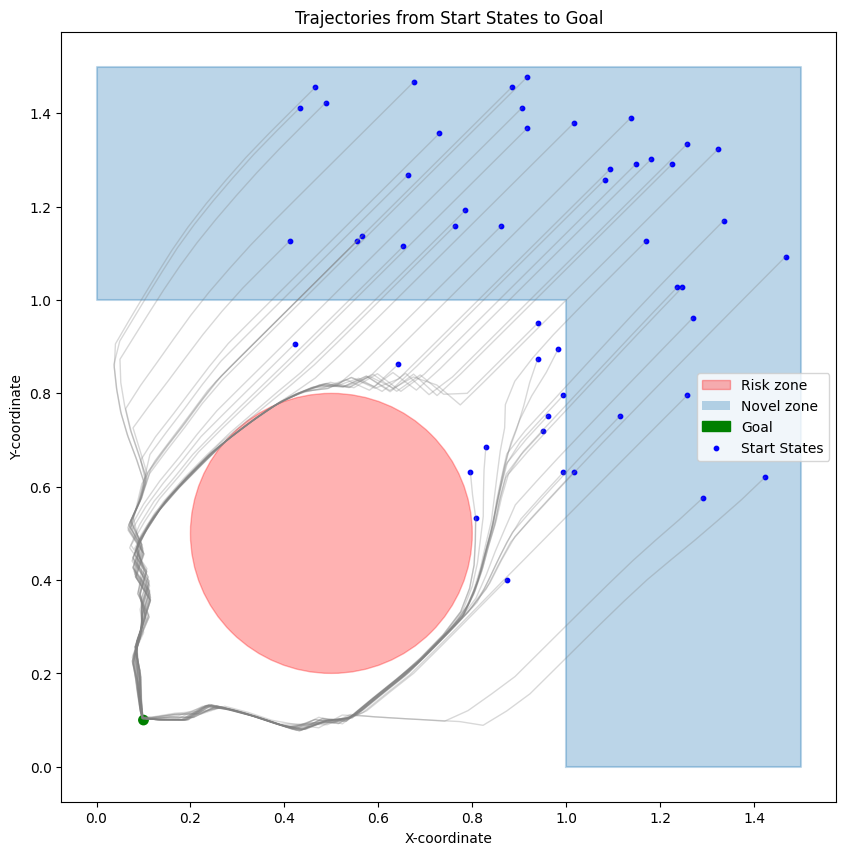

In [63]:
plot_trajectories(risky_policy)